In [6]:
%load_ext autoreload
%load_ext tensorboard
%autoreload 2
import os
import sys

import clip

import importlib

import contextlib

import json
import os
import random


sys.path.insert(0, os.path.abspath('../..'))
sys.path.insert(0, os.path.abspath('../../..'))
import numpy as np
import torch
from collections import defaultdict
from utils import get_default_path
from utils import Stopwatch
import time

import datetime


import ai.stabledisco as sd
import ai.torchmodules as torchmodules
import ai.torchmodules.data as torchdata
import ai.torchmodules.utils as torchutils
import ai.stabledisco.utils as sdutils
import ai.stabledisco.data as sddata

import torch
import torch.nn as nn
import pandas as pd

from clip.clip import _tokenizer as clip_tokenizer
import ai.stabledisco.decoderpipeline as decoderpipeline

In [7]:
import re 

# TODO: extract to class, way to many return values.
def parse_loss(training_log_lines):
    batch = []
    losses = []
    per_batch = []
    learning_rates = []
    epoch_size = None
    
    
    
    for line in training_log_lines:
        matches = re.finditer(fr"\d+(?=/)", line)
        
        if len(batch) < 2:
            for match in matches:
                batch.append(int(match.group(0).strip()))
        else:
            batch.append(batch[-1]+batch[1]-batch[0])

        if epoch_size is None:
            matches = re.finditer(fr"(?<=batch/sec) *\d+\.?\d*(?= |)", line)

            for match in matches:
                per_batch.append(float(match.group(0).strip()))


        if epoch_size is None:
            matches = re.finditer(fr"(?<=/) *\d+(?= batches)", line)
            for match in matches:
                epoch_size = int(match.group(0).strip())
            
        matches = re.finditer(fr"(?<=loss )\d+\.\d+", line)
        for match in matches:
            losses.append(float(match.group(0).strip()))
            
        matches = re.finditer(fr"(?<=Learning rate: \[)\d+\.\d+(e-?\d+)?(?=])", line)
        for match in matches:
            learning_rates.append(float(match.group(0)))
            
        
    print(epoch_size)
    return np.array(batch), epoch_size, np.mean(per_batch), np.array(losses), np.array(learning_rates)

In [12]:
training_log_lines = """
  199/52114 batches | batch/sec  2.06 | rem mins   421 | loss 1.023795 | ppl   2.7837
Learning rate: [5.593863335444058e-07]
  299/52114 batches | batch/sec  2.05 | rem mins   421 | loss 1.033931 | ppl   2.8121
Learning rate: [7.890795003166175e-07]
  399/52114 batches | batch/sec  2.05 | rem mins   420 | loss 1.035371 | ppl   2.8162
Learning rate: [1.0187726670888291e-06]
  499/52114 batches | batch/sec  2.05 | rem mins   420 | loss 1.032964 | ppl   2.8094
Learning rate: [1.2484658338610412e-06]
  599/52114 batches | batch/sec  2.05 | rem mins   419 | loss 1.023336 | ppl   2.7825
Learning rate: [1.478159000633235e-06]
  699/52114 batches | batch/sec  2.05 | rem mins   418 | loss 1.028151 | ppl   2.7959
Learning rate: [1.7078521674054467e-06]
  799/52114 batches | batch/sec  2.05 | rem mins   417 | loss 1.021082 | ppl   2.7762
Learning rate: [1.9375453341776584e-06]
  899/52114 batches | batch/sec  2.05 | rem mins   417 | loss 1.032583 | ppl   2.8083
Learning rate: [2.1672385009498527e-06]
  999/52114 batches | batch/sec  2.05 | rem mins   415 | loss 1.038315 | ppl   2.8245
Learning rate: [2.3969316677220643e-06]
 1099/52114 batches | batch/sec  2.05 | rem mins   415 | loss 1.030052 | ppl   2.8012
Learning rate: [2.626624834494276e-06]
 1199/52114 batches | batch/sec  2.05 | rem mins   414 | loss 1.028616 | ppl   2.7972
Learning rate: [2.85631800126647e-06]
 1299/52114 batches | batch/sec  2.05 | rem mins   413 | loss 1.024207 | ppl   2.7849
Learning rate: [3.086011168038682e-06]
 1399/52114 batches | batch/sec  2.05 | rem mins   412 | loss 1.015655 | ppl   2.7612
Learning rate: [3.3157043348108936e-06]
 1499/52114 batches | batch/sec  2.05 | rem mins   411 | loss 1.038145 | ppl   2.8240
Learning rate: [3.5453975015831052e-06]
 1599/52114 batches | batch/sec  2.05 | rem mins   411 | loss 1.027442 | ppl   2.7939
Learning rate: [3.775090668355299e-06]
 1699/52114 batches | batch/sec  2.05 | rem mins   410 | loss 1.025032 | ppl   2.7872
Learning rate: [4.004783835127511e-06]
 1799/52114 batches | batch/sec  2.05 | rem mins   409 | loss 1.030750 | ppl   2.8032
Learning rate: [4.234477001899722e-06]
 1899/52114 batches | batch/sec  2.05 | rem mins   408 | loss 1.028744 | ppl   2.7976
Learning rate: [4.464170168671917e-06]
 1999/52114 batches | batch/sec  2.05 | rem mins   408 | loss 1.020364 | ppl   2.7742
Learning rate: [4.693863335444129e-06]
 2099/52114 batches | batch/sec  2.05 | rem mins   407 | loss 1.028286 | ppl   2.7963
Learning rate: [4.92355650221634e-06]
 2199/52114 batches | batch/sec  2.05 | rem mins   406 | loss 1.031961 | ppl   2.8066
Learning rate: [5.153249668988552e-06]
 2299/52114 batches | batch/sec  2.05 | rem mins   405 | loss 1.025700 | ppl   2.7890
Learning rate: [5.382942835760746e-06]
 2399/52114 batches | batch/sec  2.05 | rem mins   405 | loss 1.026456 | ppl   2.7912
Learning rate: [5.612636002532958e-06]
 2499/52114 batches | batch/sec  2.05 | rem mins   404 | loss 1.020602 | ppl   2.7749
Learning rate: [5.842329169305169e-06]
 2599/52114 batches | batch/sec  2.05 | rem mins   403 | loss 1.034597 | ppl   2.8140
Learning rate: [6.072022336077364e-06]
 2699/52114 batches | batch/sec  2.05 | rem mins   403 | loss 1.031363 | ppl   2.8049
Learning rate: [6.301715502849576e-06]
 2799/52114 batches | batch/sec  2.05 | rem mins   402 | loss 1.028852 | ppl   2.7979
Learning rate: [6.531408669621787e-06]
 2899/52114 batches | batch/sec  2.05 | rem mins   401 | loss 1.030864 | ppl   2.8035
Learning rate: [6.761101836393999e-06]
 2999/52114 batches | batch/sec  2.05 | rem mins   400 | loss 1.032673 | ppl   2.8086
Learning rate: [6.990795003166193e-06]
 3099/52114 batches | batch/sec  2.05 | rem mins   399 | loss 1.032818 | ppl   2.8090
Learning rate: [7.220488169938404e-06]
 3199/52114 batches | batch/sec  2.05 | rem mins   399 | loss 1.018828 | ppl   2.7699
Learning rate: [7.450181336710616e-06]
 3299/52114 batches | batch/sec  2.05 | rem mins   398 | loss 1.024915 | ppl   2.7869
Learning rate: [7.67987450348281e-06]
 3399/52114 batches | batch/sec  2.05 | rem mins   397 | loss 1.025864 | ppl   2.7895
Learning rate: [7.909567670255022e-06]
 3499/52114 batches | batch/sec  2.04 | rem mins   396 | loss 1.028994 | ppl   2.7983
Learning rate: [8.139260837027234e-06]
 3599/52114 batches | batch/sec  2.05 | rem mins   395 | loss 1.028517 | ppl   2.7969
Learning rate: [8.368954003799429e-06]
 3699/52114 batches | batch/sec  2.04 | rem mins   395 | loss 1.032255 | ppl   2.8074
Learning rate: [8.59864717057164e-06]
 3799/52114 batches | batch/sec  2.05 | rem mins   393 | loss 1.024731 | ppl   2.7863
Learning rate: [8.828340337343852e-06]
 3899/52114 batches | batch/sec  2.05 | rem mins   393 | loss 1.032492 | ppl   2.8081
Learning rate: [9.058033504116064e-06]
 3999/52114 batches | batch/sec  2.05 | rem mins   391 | loss 1.029576 | ppl   2.7999
Learning rate: [9.287726670888258e-06]
 4099/52114 batches | batch/sec  2.05 | rem mins   391 | loss 1.032137 | ppl   2.8071
Learning rate: [9.51741983766047e-06]
 4199/52114 batches | batch/sec  2.04 | rem mins   391 | loss 1.028218 | ppl   2.7961
Learning rate: [9.747113004432682e-06]
 4299/52114 batches | batch/sec  2.04 | rem mins   390 | loss 1.026587 | ppl   2.7915
Learning rate: [9.976806171204875e-06]
 4399/52114 batches | batch/sec  2.05 | rem mins   389 | loss 1.029237 | ppl   2.7989
Learning rate: [1.0206499337977088e-05]
 4499/52114 batches | batch/sec  2.05 | rem mins   387 | loss 1.029093 | ppl   2.7985
Learning rate: [1.04361925047493e-05]
 4599/52114 batches | batch/sec  2.05 | rem mins   387 | loss 1.026362 | ppl   2.7909
Learning rate: [1.0665885671521493e-05]
 4699/52114 batches | batch/sec  2.04 | rem mins   387 | loss 1.039522 | ppl   2.8279
Learning rate: [1.0895578838293704e-05]
 4799/52114 batches | batch/sec  2.05 | rem mins   385 | loss 1.031391 | ppl   2.8050
Learning rate: [1.1125272005065916e-05]
 4899/52114 batches | batch/sec  2.05 | rem mins   384 | loss 1.024400 | ppl   2.7854
Learning rate: [1.1354965171838128e-05]
 4999/52114 batches | batch/sec  2.05 | rem mins   384 | loss 1.027093 | ppl   2.7929
Learning rate: [1.1584658338610322e-05]
""".split('\n')


In [ ]:

batches, epoch_size, sec_per_batch, losses, learning_rates = parse_loss(training_log_lines)
print(parse_loss(training_log_lines))

52114
[1.023795 1.033931 1.035371 1.032964 1.023336 1.028151 1.021082 1.032583
 1.038315 1.030052 1.028616 1.024207 1.015655 1.038145 1.027442 1.025032
 1.03075  1.028744 1.020364 1.028286 1.031961 1.0257   1.026456 1.020602
 1.034597 1.031363 1.028852 1.030864 1.032673 1.032818 1.018828 1.024915
 1.025864 1.028994 1.028517 1.032255 1.024731 1.032492 1.029576 1.032137
 1.028218 1.026587 1.029237 1.029093 1.026362 1.039522 1.031391 1.0244
 1.027093]
[5.59386334e-07 7.89079500e-07 1.01877267e-06 1.24846583e-06
 1.47815900e-06 1.70785217e-06 1.93754533e-06 2.16723850e-06
 2.39693167e-06 2.62662483e-06 2.85631800e-06 3.08601117e-06
 3.31570433e-06 3.54539750e-06 3.77509067e-06 4.00478384e-06
 4.23447700e-06 4.46417017e-06 4.69386334e-06 4.92355650e-06
 5.15324967e-06 5.38294284e-06 5.61263600e-06 5.84232917e-06
 6.07202234e-06 6.30171550e-06 6.53140867e-06 6.76110184e-06
 6.99079500e-06 7.22048817e-06 7.45018134e-06 7.67987450e-06
 7.90956767e-06 8.13926084e-06 8.36895400e-06 8.59864717e-0

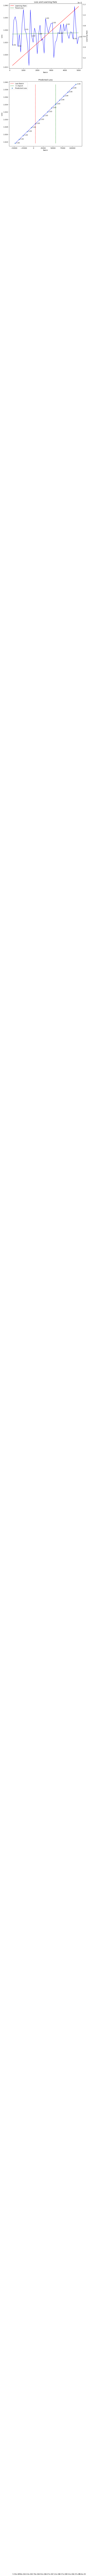

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import utils
batches, epoch_size, sec_per_batch, losses, learning_rates = parse_loss(training_log_lines)
def smooth(data, window_width):
    ret = np.cumsum(np.insert(data, 0, 0)) 
    return (ret[window_width:] - ret[:-window_width]) / window_width
    
smooth_window = 1
start_idx = 0
end_idx = len(losses)
#end_idx -= 20

smooth_batches = smooth(batches[start_idx:end_idx], smooth_window)
smooth_loss = smooth(losses[start_idx:end_idx], smooth_window)
smooth_learning = smooth(learning_rates[start_idx:end_idx], smooth_window)
print(smooth_loss)
print(smooth_learning)

print(max(learning_rates))
a, y = np.polyfit(smooth_batches, np.log(smooth_loss), 1)

def predicted_value(x, a, y):
    return np.exp(a*x) * np.exp(y)

y_vals = predicted_value(smooth_batches, a, y)

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 16), dpi=80)
ax1.set_title("Loss and Learning Rate")
ax3.set_title("Predicted Loss")
ax3.set_xlabel("Batch")
ax3.set_ylabel("Loss")

ax2 = ax1.twinx()

print(f"y = {a}x + {y}")

ax1.set_xlabel("Batch")
ax1.set_ylabel("Loss")
ax1.plot(smooth_batches, smooth_loss, label="Loss", color="blue")
ax1.plot(smooth_batches, y_vals, label="Trend Line", linestyle="--", color="green")

ax2.set_xlabel("Batch")
ax2.set_ylabel("Learning Rate")
ax2.plot(smooth_batches, smooth_learning, label="Learning Rate", color="red")

predict_batch = []
predicted_loss = []
last_batch = smooth_batches[-1]
loss_height = max(smooth_loss) - min(smooth_loss)
learning_height = max(smooth_learning) - min(smooth_learning)
for perc in np.arange(0, 1.1, 0.1):
    batch_idx = int(len(smooth_batches) * perc)
    batch_idx = min(batch_idx, len(smooth_batches)-1)
    print(batch_idx)
    
    batch = smooth_batches[batch_idx]
    loss_y = smooth_loss[batch_idx]
    ax1.text(batch, loss_y, f"{loss_y:.3g}", size=10)
    
    learning_y = smooth_learning[batch_idx]
    ax1.text(batch, learning_y, f"{learning_y:.3g}", size=10)


total_width = smooth_batches[0] + epoch_size 
def calc_point(ax, add, a, y, text_size=10):
    x = utils.round_to_multiple(last_batch + add, 100)
    y = predicted_value(x, a, y)

    predict_batch.append(x)
    predicted_loss.append(y)
    
    ax.text(x+0.05*total_width, y, f"{y:.3g}", size=text_size)
    add_hours = add/sec_per_batch/3600
    print(f"{add/epoch_size:+0.2f}% epoches | {add_hours:+06.2f} hours | batch {int(x):>8d}: {y:06.3f} | {np.exp(y):0.3f}")



#fig, ax3 = plt.subplots()

for percent_future in np.arange(-1.0, 2.1, 0.2):
    calc_point(ax3, epoch_size*percent_future, a, y)


ax3.plot([last_batch, last_batch], [min(predicted_loss), max(predicted_loss)], linestyle="--", color="red", label="Last Batch") 

ax3.plot([last_batch+epoch_size, last_batch+epoch_size], [min(predicted_loss), max(predicted_loss)], linestyle="--", color="green", label="+1 Epoch") 
margin = (predict_batch[-1] - predict_batch[0]) * 0.1
percent_finished = smooth_batches[-1] / epoch_size


ax3.set_xlim(predict_batch[0]-margin, predict_batch[-1]+margin)
ax3.plot(predict_batch, predicted_loss, linestyle='--', color="blue")
ax3.scatter(predict_batch, predicted_loss, marker="x", label="Predicted Loss")

ax1.legend()
ax2.legend()
ax3.legend()
fig.show()

In [1]:
training_log_lines = """
Starting training
Starting epoch 0
   99/58367 batches | batch/sec  1.34 | rem mins   722 | loss 1.032029 | ppl   2.8068
Learning rate: [1.0479731350443782e-05]
  199/58367 batches | batch/sec  2.05 | rem mins   472 | loss 1.028975 | ppl   2.7982
Learning rate: [1.0959462700887502e-05]
  299/58367 batches | batch/sec  2.05 | rem mins   472 | loss 1.029672 | ppl   2.8001
Learning rate: [1.1439194051331283e-05]
  399/58367 batches | batch/sec  2.05 | rem mins   472 | loss 1.033171 | ppl   2.8100
Learning rate: [1.1918925401775003e-05]
  499/58367 batches | batch/sec  2.05 | rem mins   471 | loss 1.027274 | ppl   2.7934
Learning rate: [1.2398656752218785e-05]
  599/58367 batches | batch/sec  2.05 | rem mins   470 | loss 1.029117 | ppl   2.7986
Learning rate: [1.2878388102662503e-05]
  699/58367 batches | batch/sec  2.05 | rem mins   470 | loss 1.032396 | ppl   2.8078
Learning rate: [1.3358119453106286e-05]
  799/58367 batches | batch/sec  2.05 | rem mins   469 | loss 1.027453 | ppl   2.7939
Learning rate: [1.3837850803550004e-05]
  899/58367 batches | batch/sec  2.05 | rem mins   468 | loss 1.022352 | ppl   2.7797
Learning rate: [1.4317582153993787e-05]
  999/58367 batches | batch/sec  2.05 | rem mins   468 | loss 1.027938 | ppl   2.7953
Learning rate: [1.4797313504437506e-05]
 1099/58367 batches | batch/sec  2.05 | rem mins   467 | loss 1.024437 | ppl   2.7855
Learning rate: [1.5277044854881287e-05]
 1199/58367 batches | batch/sec  2.05 | rem mins   466 | loss 1.031851 | ppl   2.8063
Learning rate: [1.5756776205325007e-05]
 1299/58367 batches | batch/sec  2.05 | rem mins   465 | loss 1.029954 | ppl   2.8009
Learning rate: [1.6236507555768788e-05]
 1399/58367 batches | batch/sec  2.05 | rem mins   464 | loss 1.024873 | ppl   2.7867
Learning rate: [1.671623890621251e-05]
 1499/58367 batches | batch/sec  2.05 | rem mins   463 | loss 1.028943 | ppl   2.7981
Learning rate: [1.719597025665629e-05]
 1599/58367 batches | batch/sec  2.05 | rem mins   462 | loss 1.034703 | ppl   2.8143
Learning rate: [1.767570160710001e-05]
 1699/58367 batches | batch/sec  2.04 | rem mins   462 | loss 1.015022 | ppl   2.7594
Learning rate: [1.815543295754379e-05]
 1799/58367 batches | batch/sec  2.04 | rem mins   461 | loss 1.014339 | ppl   2.7575
Learning rate: [1.863516430798751e-05]
 1899/58367 batches | batch/sec  2.05 | rem mins   460 | loss 1.035722 | ppl   2.8171
Learning rate: [1.9114895658431292e-05]
 1999/58367 batches | batch/sec  2.05 | rem mins   459 | loss 1.028476 | ppl   2.7968
Learning rate: [1.9594627008875012e-05]
 2099/58367 batches | batch/sec  2.04 | rem mins   459 | loss 1.023482 | ppl   2.7829
Learning rate: [2.0074358359318793e-05]
 2199/58367 batches | batch/sec  2.05 | rem mins   458 | loss 1.025941 | ppl   2.7897
Learning rate: [2.0554089709762514e-05]
 2299/58367 batches | batch/sec  2.05 | rem mins   457 | loss 1.019142 | ppl   2.7708
Learning rate: [2.1033821060206295e-05]
 2399/58367 batches | batch/sec  2.05 | rem mins   456 | loss 1.026712 | ppl   2.7919
Learning rate: [2.1513552410650015e-05]
 2499/58367 batches | batch/sec  2.04 | rem mins   456 | loss 1.022603 | ppl   2.7804
Learning rate: [2.1993283761093796e-05]
 2599/58367 batches | batch/sec  2.05 | rem mins   454 | loss 1.023876 | ppl   2.7840
Learning rate: [2.2473015111537516e-05]
 2699/58367 batches | batch/sec  2.04 | rem mins   454 | loss 1.036367 | ppl   2.8190
Learning rate: [2.2952746461981297e-05]
 2799/58367 batches | batch/sec  2.05 | rem mins   453 | loss 1.024865 | ppl   2.7867
Learning rate: [2.3432477812425018e-05]
 2899/58367 batches | batch/sec  2.04 | rem mins   452 | loss 1.023504 | ppl   2.7829
Learning rate: [2.39122091628688e-05]
 2999/58367 batches | batch/sec  2.05 | rem mins   451 | loss 1.014534 | ppl   2.7581
Learning rate: [2.439194051331252e-05]
 3099/58367 batches | batch/sec  2.04 | rem mins   450 | loss 1.029050 | ppl   2.7984
Learning rate: [2.48716718637563e-05]
 3199/58367 batches | batch/sec  2.05 | rem mins   450 | loss 1.021724 | ppl   2.7780
Learning rate: [2.535140321420002e-05]
 3299/58367 batches | batch/sec  2.04 | rem mins   449 | loss 1.025447 | ppl   2.7883
Learning rate: [2.58311345646438e-05]
 3399/58367 batches | batch/sec  2.05 | rem mins   448 | loss 1.020811 | ppl   2.7754
Learning rate: [2.6310865915087582e-05]
 3499/58367 batches | batch/sec  2.04 | rem mins   447 | loss 1.039893 | ppl   2.8289
Learning rate: [2.6790597265531303e-05]
 3599/58367 batches | batch/sec  2.05 | rem mins   446 | loss 1.019992 | ppl   2.7732
Learning rate: [2.7270328615975084e-05]
 3699/58367 batches | batch/sec  2.05 | rem mins   445 | loss 1.031026 | ppl   2.8039
Learning rate: [2.7750059966418804e-05]
 3799/58367 batches | batch/sec  2.05 | rem mins   445 | loss 1.030329 | ppl   2.8020
Learning rate: [2.8229791316862585e-05]
 3899/58367 batches | batch/sec  2.04 | rem mins   444 | loss 1.027337 | ppl   2.7936
Learning rate: [2.8709522667306305e-05]
 3999/58367 batches | batch/sec  2.04 | rem mins   443 | loss 1.033892 | ppl   2.8120
Learning rate: [2.9189254017750086e-05]
 4099/58367 batches | batch/sec  2.04 | rem mins   443 | loss 1.026938 | ppl   2.7925
Learning rate: [2.9668985368193807e-05]
 4199/58367 batches | batch/sec  2.04 | rem mins   442 | loss 1.031494 | ppl   2.8053
Learning rate: [3.0148716718637588e-05]
 4299/58367 batches | batch/sec  2.04 | rem mins   441 | loss 1.023508 | ppl   2.7829
Learning rate: [3.062844806908131e-05]
 4399/58367 batches | batch/sec  2.04 | rem mins   442 | loss 1.031366 | ppl   2.8049
Learning rate: [3.110817941952509e-05]
 4499/58367 batches | batch/sec  2.04 | rem mins   439 | loss 1.036422 | ppl   2.8191
Learning rate: [3.158791076996881e-05]
 4599/58367 batches | batch/sec  2.04 | rem mins   439 | loss 1.025136 | ppl   2.7875
Learning rate: [3.206764212041259e-05]
 4699/58367 batches | batch/sec  2.05 | rem mins   437 | loss 1.035614 | ppl   2.8168
Learning rate: [3.254737347085631e-05]
 4799/58367 batches | batch/sec  2.04 | rem mins   437 | loss 1.028795 | ppl   2.7977
Learning rate: [3.302710482130009e-05]
 4899/58367 batches | batch/sec  2.05 | rem mins   436 | loss 1.027238 | ppl   2.7933
Learning rate: [3.350683617174381e-05]
 4999/58367 batches | batch/sec  2.04 | rem mins   435 | loss 1.022256 | ppl   2.7795
Learning rate: [3.398656752218759e-05]
 5099/58367 batches | batch/sec  2.04 | rem mins   434 | loss 1.030576 | ppl   2.8027
Learning rate: [3.446629887263131e-05]
 5199/58367 batches | batch/sec  2.04 | rem mins   434 | loss 1.024501 | ppl   2.7857
Learning rate: [3.4946030223075094e-05]
 5299/58367 batches | batch/sec  2.04 | rem mins   433 | loss 1.030354 | ppl   2.8021
Learning rate: [3.5425761573518814e-05]
 5399/58367 batches | batch/sec  2.05 | rem mins   431 | loss 1.034045 | ppl   2.8124
Learning rate: [3.5905492923962596e-05]
 5499/58367 batches | batch/sec  2.04 | rem mins   431 | loss 1.027297 | ppl   2.7935
Learning rate: [3.638522427440631e-05]
 5599/58367 batches | batch/sec  2.04 | rem mins   430 | loss 1.023908 | ppl   2.7841
Learning rate: [3.68649556248501e-05]
 5699/58367 batches | batch/sec  2.05 | rem mins   429 | loss 1.026094 | ppl   2.7901
Learning rate: [3.734468697529381e-05]
 5799/58367 batches | batch/sec  2.04 | rem mins   429 | loss 1.017072 | ppl   2.7651
Learning rate: [3.78244183257376e-05]
 5899/58367 batches | batch/sec  2.05 | rem mins   428 | loss 1.024482 | ppl   2.7857
Learning rate: [3.830414967618131e-05]
 5999/58367 batches | batch/sec  2.05 | rem mins   427 | loss 1.023522 | ppl   2.7830
Learning rate: [3.878388102662509e-05]
 6099/58367 batches | batch/sec  2.04 | rem mins   426 | loss 1.019090 | ppl   2.7707
Learning rate: [3.926361237706881e-05]
 6199/58367 batches | batch/sec  2.04 | rem mins   425 | loss 1.024208 | ppl   2.7849
Learning rate: [3.9743343727512594e-05]
 6299/58367 batches | batch/sec  2.04 | rem mins   424 | loss 1.027660 | ppl   2.7945
Learning rate: [4.0223075077956314e-05]
 6399/58367 batches | batch/sec  2.04 | rem mins   424 | loss 1.022457 | ppl   2.7800
Learning rate: [4.0702806428400095e-05]
 6499/58367 batches | batch/sec  2.04 | rem mins   423 | loss 1.020762 | ppl   2.7753
Learning rate: [4.1182537778843816e-05]
 6599/58367 batches | batch/sec  2.05 | rem mins   421 | loss 1.029816 | ppl   2.8006
Learning rate: [4.16622691292876e-05]
 6699/58367 batches | batch/sec  2.04 | rem mins   421 | loss 1.030880 | ppl   2.8035
Learning rate: [4.214200047973138e-05]
 6799/58367 batches | batch/sec  2.04 | rem mins   421 | loss 1.024141 | ppl   2.7847
Learning rate: [4.26217318301751e-05]
 6899/58367 batches | batch/sec  2.04 | rem mins   419 | loss 1.035447 | ppl   2.8164
Learning rate: [4.310146318061882e-05]
 6999/58367 batches | batch/sec  2.05 | rem mins   418 | loss 1.015131 | ppl   2.7597
Learning rate: [4.35811945310626e-05]
 7099/58367 batches | batch/sec  2.04 | rem mins   418 | loss 1.024076 | ppl   2.7845
Learning rate: [4.406092588150638e-05]
 7199/58367 batches | batch/sec  2.05 | rem mins   417 | loss 1.019199 | ppl   2.7710
Learning rate: [4.45406572319501e-05]
 7299/58367 batches | batch/sec  2.05 | rem mins   416 | loss 1.024315 | ppl   2.7852
Learning rate: [4.502038858239388e-05]
 7399/58367 batches | batch/sec  2.05 | rem mins   415 | loss 1.026300 | ppl   2.7907
Learning rate: [4.55001199328376e-05]
 7499/58367 batches | batch/sec  2.05 | rem mins   414 | loss 1.025358 | ppl   2.7881
Learning rate: [4.597985128328138e-05]
 7599/58367 batches | batch/sec  2.05 | rem mins   413 | loss 1.025924 | ppl   2.7897
Learning rate: [4.64595826337251e-05]
 7699/58367 batches | batch/sec  2.04 | rem mins   413 | loss 1.030289 | ppl   2.8019
Learning rate: [4.6939313984168884e-05]
 7799/58367 batches | batch/sec  2.04 | rem mins   412 | loss 1.030852 | ppl   2.8035
Learning rate: [4.7419045334612605e-05]
 7899/58367 batches | batch/sec  2.05 | rem mins   411 | loss 1.020260 | ppl   2.7739
Learning rate: [4.7898776685056386e-05]
 7999/58367 batches | batch/sec  2.05 | rem mins   410 | loss 1.034700 | ppl   2.8143
Learning rate: [4.8378508035500106e-05]
 8099/58367 batches | batch/sec  2.04 | rem mins   410 | loss 1.022487 | ppl   2.7801
Learning rate: [4.885823938594389e-05]
 8199/58367 batches | batch/sec  2.04 | rem mins   409 | loss 1.026318 | ppl   2.7908
Learning rate: [4.933797073638761e-05]
 8299/58367 batches | batch/sec  2.04 | rem mins   408 | loss 1.028206 | ppl   2.7960
Learning rate: [4.981770208683139e-05]
 8399/58367 batches | batch/sec  2.05 | rem mins   407 | loss 1.032065 | ppl   2.8069
Learning rate: [5.029743343727511e-05]
 8499/58367 batches | batch/sec  2.04 | rem mins   407 | loss 1.022524 | ppl   2.7802
Learning rate: [5.077716478771889e-05]
 8599/58367 batches | batch/sec  2.04 | rem mins   406 | loss 1.022584 | ppl   2.7804
Learning rate: [5.125689613816261e-05]
 8699/58367 batches | batch/sec  2.05 | rem mins   404 | loss 1.031084 | ppl   2.8041
Learning rate: [5.173662748860639e-05]
""".split("\n")

In [ ]:
training_log_lines = """
Starting training
Starting epoch 0
  200/47582 batches | batch/sec  1.86 | rem mins   426 | loss 1.18771 | ppl   3.2796
Learning rate: [9.011381334611244e-06]
  400/47582 batches | batch/sec  1.92 | rem mins   409 | loss 1.18449 | ppl   3.2690
Learning rate: [1.0017730921289078e-05]
  600/47582 batches | batch/sec  1.92 | rem mins   409 | loss 1.18901 | ppl   3.2838
Learning rate: [1.102408050796693e-05]
  800/47582 batches | batch/sec  1.92 | rem mins   407 | loss 1.18701 | ppl   3.2773
Learning rate: [1.2030430094644783e-05]
 1000/47582 batches | batch/sec  1.91 | rem mins   406 | loss 1.18836 | ppl   3.2817
Learning rate: [1.3036779681322636e-05]
 1200/47582 batches | batch/sec  1.91 | rem mins   404 | loss 1.18720 | ppl   3.2779
Learning rate: [1.4043129268000486e-05]
 1400/47582 batches | batch/sec  1.92 | rem mins   402 | loss 1.17720 | ppl   3.2453
Learning rate: [1.5049478854678321e-05]
 1600/47582 batches | batch/sec  1.91 | rem mins   400 | loss 1.18512 | ppl   3.2711
Learning rate: [1.6055828441356173e-05]
 1800/47582 batches | batch/sec  1.92 | rem mins   398 | loss 1.18287 | ppl   3.2637
Learning rate: [1.7062178028034026e-05]
 2000/47582 batches | batch/sec  1.92 | rem mins   396 | loss 1.18703 | ppl   3.2773
Learning rate: [1.806852761471188e-05]
 2200/47582 batches | batch/sec  1.92 | rem mins   395 | loss 1.18528 | ppl   3.2716
Learning rate: [1.9074877201389713e-05]
 2400/47582 batches | batch/sec  1.92 | rem mins   393 | loss 1.17889 | ppl   3.2507
Learning rate: [2.0081226788067566e-05]
 2600/47582 batches | batch/sec  1.92 | rem mins   391 | loss 1.18701 | ppl   3.2773
Learning rate: [2.1087576374745416e-05]
 2800/47582 batches | batch/sec  1.92 | rem mins   389 | loss 1.18456 | ppl   3.2693
Learning rate: [2.2093925961423267e-05]
 3000/47582 batches | batch/sec  1.92 | rem mins   387 | loss 1.19000 | ppl   3.2871
Learning rate: [2.310027554810112e-05]
 3200/47582 batches | batch/sec  1.92 | rem mins   386 | loss 1.18916 | ppl   3.2843
Learning rate: [2.4106625134778953e-05]
 3400/47582 batches | batch/sec  1.92 | rem mins   383 | loss 1.18720 | ppl   3.2779
Learning rate: [2.5112974721456807e-05]
 3600/47582 batches | batch/sec  1.92 | rem mins   382 | loss 1.19037 | ppl   3.2883
Learning rate: [2.611932430813466e-05]
 3800/47582 batches | batch/sec  1.92 | rem mins   380 | loss 1.18927 | ppl   3.2847
Learning rate: [2.7125673894812514e-05]
 4000/47582 batches | batch/sec  1.92 | rem mins   378 | loss 1.17973 | ppl   3.2535
Learning rate: [2.8132023481490367e-05]
 4200/47582 batches | batch/sec  1.92 | rem mins   377 | loss 1.18300 | ppl   3.2641
Learning rate: [2.91383730681682e-05]
 4400/47582 batches | batch/sec  1.92 | rem mins   375 | loss 1.17930 | ppl   3.2521
Learning rate: [3.0144722654846054e-05]
 4600/47582 batches | batch/sec  1.92 | rem mins   373 | loss 1.18891 | ppl   3.2835
Learning rate: [3.11510722415239e-05]
 4800/47582 batches | batch/sec  1.92 | rem mins   371 | loss 1.18340 | ppl   3.2655
Learning rate: [3.2157421828201754e-05]
 5000/47582 batches | batch/sec  1.92 | rem mins   370 | loss 1.18598 | ppl   3.2739
Learning rate: [3.316377141487961e-05]
 5200/47582 batches | batch/sec  1.92 | rem mins   368 | loss 1.18851 | ppl   3.2822
Learning rate: [3.417012100155744e-05]
 5400/47582 batches | batch/sec  1.92 | rem mins   366 | loss 1.18282 | ppl   3.2636
Learning rate: [3.5176470588235294e-05]
 5600/47582 batches | batch/sec  1.92 | rem mins   364 | loss 1.18755 | ppl   3.2790
Learning rate: [3.618282017491315e-05]
 5800/47582 batches | batch/sec  1.92 | rem mins   363 | loss 1.18526 | ppl   3.2715
Learning rate: [3.7189169761591e-05]
 6000/47582 batches | batch/sec  1.92 | rem mins   361 | loss 1.18530 | ppl   3.2717
Learning rate: [3.819551934826885e-05]
 6200/47582 batches | batch/sec  1.92 | rem mins   360 | loss 1.19090 | ppl   3.2901
Learning rate: [3.920186893494668e-05]
 6400/47582 batches | batch/sec  1.92 | rem mins   358 | loss 1.18311 | ppl   3.2645
Learning rate: [4.0208218521624534e-05]
 6600/47582 batches | batch/sec  1.91 | rem mins   357 | loss 1.18246 | ppl   3.2624
Learning rate: [4.121456810830239e-05]
 6800/47582 batches | batch/sec  1.91 | rem mins   355 | loss 1.18040 | ppl   3.2557
Learning rate: [4.222091769498024e-05]
 7000/47582 batches | batch/sec  1.91 | rem mins   354 | loss 1.18359 | ppl   3.2661
Learning rate: [4.3227267281658094e-05]
 7200/47582 batches | batch/sec  1.91 | rem mins   352 | loss 1.18374 | ppl   3.2666
Learning rate: [4.423361686833593e-05]
 7400/47582 batches | batch/sec  1.91 | rem mins   350 | loss 1.17609 | ppl   3.2417
Learning rate: [4.523996645501378e-05]
 7600/47582 batches | batch/sec  1.91 | rem mins   348 | loss 1.18463 | ppl   3.2695
Learning rate: [4.624631604169163e-05]
 7800/47582 batches | batch/sec  1.91 | rem mins   347 | loss 1.18499 | ppl   3.2706
Learning rate: [4.725266562836948e-05]
 8000/47582 batches | batch/sec  1.91 | rem mins   345 | loss 1.18341 | ppl   3.2655
Learning rate: [4.8259015215047334e-05]
 8200/47582 batches | batch/sec  1.91 | rem mins   343 | loss 1.18707 | ppl   3.2775
Learning rate: [4.926536480172517e-05]
 8400/47582 batches | batch/sec  1.91 | rem mins   341 | loss 1.18863 | ppl   3.2826
Learning rate: [4.9728285611596984e-05]
 8600/47582 batches | batch/sec  1.92 | rem mins   339 | loss 1.18527 | ppl   3.2716
Learning rate: [4.872193602491913e-05]
 8800/47582 batches | batch/sec  1.92 | rem mins   337 | loss 1.18253 | ppl   3.2626
Learning rate: [4.77155864382413e-05]
 9000/47582 batches | batch/sec  1.92 | rem mins   336 | loss 1.18016 | ppl   3.2549
Learning rate: [4.670923685156343e-05]
 9200/47582 batches | batch/sec  1.92 | rem mins   334 | loss 1.18141 | ppl   3.2590
Learning rate: [4.570288726488559e-05]
 9400/47582 batches | batch/sec  1.92 | rem mins   332 | loss 1.18692 | ppl   3.2770
Learning rate: [4.4696537678207744e-05]
 9600/47582 batches | batch/sec  1.92 | rem mins   330 | loss 1.18751 | ppl   3.2789
Learning rate: [4.369018809152989e-05]
 9800/47582 batches | batch/sec  1.92 | rem mins   329 | loss 1.18454 | ppl   3.2692
Learning rate: [4.268383850485206e-05]
10000/47582 batches | batch/sec  1.92 | rem mins   327 | loss 1.17794 | ppl   3.2477
Learning rate: [4.167748891817418e-05]
10200/47582 batches | batch/sec  1.92 | rem mins   325 | loss 1.17651 | ppl   3.2430
Learning rate: [4.067113933149635e-05]
10400/47582 batches | batch/sec  1.92 | rem mins   323 | loss 1.18883 | ppl   3.2832
Learning rate: [3.9664789744818497e-05]
10600/47582 batches | batch/sec  1.92 | rem mins   321 | loss 1.18893 | ppl   3.2836
Learning rate: [3.865844015814064e-05]
10800/47582 batches | batch/sec  1.92 | rem mins   320 | loss 1.18309 | ppl   3.2645
Learning rate: [3.765209057146282e-05]
11000/47582 batches | batch/sec  1.92 | rem mins   318 | loss 1.18503 | ppl   3.2708
Learning rate: [3.664574098478494e-05]
11200/47582 batches | batch/sec  1.92 | rem mins   316 | loss 1.17941 | ppl   3.2525
Learning rate: [3.563939139810711e-05]
11400/47582 batches | batch/sec  1.92 | rem mins   314 | loss 1.18137 | ppl   3.2588
Learning rate: [3.4633041811429256e-05]
11600/47582 batches | batch/sec  1.92 | rem mins   312 | loss 1.18312 | ppl   3.2645
Learning rate: [3.36266922247514e-05]
11800/47582 batches | batch/sec  1.92 | rem mins   311 | loss 1.18062 | ppl   3.2564
Learning rate: [3.262034263807357e-05]
12000/47582 batches | batch/sec  1.92 | rem mins   309 | loss 1.18715 | ppl   3.2777
Learning rate: [3.1613993051395696e-05]
12200/47582 batches | batch/sec  1.92 | rem mins   307 | loss 1.18627 | ppl   3.2748
Learning rate: [3.060764346471786e-05]
12400/47582 batches | batch/sec  1.92 | rem mins   306 | loss 1.17812 | ppl   3.2483
Learning rate: [2.9601293878040016e-05]
12600/47582 batches | batch/sec  1.92 | rem mins   304 | loss 1.18968 | ppl   3.2860
Learning rate: [2.8594944291362163e-05]
12800/47582 batches | batch/sec  1.92 | rem mins   302 | loss 1.18096 | ppl   3.2575
Learning rate: [2.758859470468433e-05]
13000/47582 batches | batch/sec  1.92 | rem mins   301 | loss 1.18269 | ppl   3.2631
Learning rate: [2.6582245118006476e-05]
13200/47582 batches | batch/sec  1.92 | rem mins   299 | loss 1.18019 | ppl   3.2550
Learning rate: [2.5575895531328623e-05]
13400/47582 batches | batch/sec  1.92 | rem mins   297 | loss 1.19214 | ppl   3.2941
Learning rate: [2.456954594465077e-05]
13600/47582 batches | batch/sec  1.92 | rem mins   295 | loss 1.18581 | ppl   3.2733
Learning rate: [2.3563196357972916e-05]
13800/47582 batches | batch/sec  1.92 | rem mins   293 | loss 1.18106 | ppl   3.2578
Learning rate: [2.2556846771295083e-05]
14000/47582 batches | batch/sec  1.92 | rem mins   291 | loss 1.18332 | ppl   3.2652
Learning rate: [2.1550497184617233e-05]
14200/47582 batches | batch/sec  1.92 | rem mins   290 | loss 1.18411 | ppl   3.2678
Learning rate: [2.054414759793938e-05]
14400/47582 batches | batch/sec  1.92 | rem mins   288 | loss 1.17881 | ppl   3.2505
Learning rate: [1.9537798011261546e-05]
14600/47582 batches | batch/sec  1.92 | rem mins   286 | loss 1.17913 | ppl   3.2515
Learning rate: [1.8531448424583676e-05]
14800/47582 batches | batch/sec  1.92 | rem mins   285 | loss 1.17379 | ppl   3.2342
Learning rate: [1.7525098837905842e-05]
15000/47582 batches | batch/sec  1.92 | rem mins   283 | loss 1.17950 | ppl   3.2527
Learning rate: [1.651874925122799e-05]
15200/47582 batches | batch/sec  1.92 | rem mins   281 | loss 1.18738 | ppl   3.2785
Learning rate: [1.5512399664550136e-05]
15400/47582 batches | batch/sec  1.92 | rem mins   279 | loss 1.18409 | ppl   3.2677
Learning rate: [1.4506050077872302e-05]
15600/47582 batches | batch/sec  1.92 | rem mins   278 | loss 1.18275 | ppl   3.2633
Learning rate: [1.3499700491194432e-05]
15800/47582 batches | batch/sec  1.92 | rem mins   276 | loss 1.18046 | ppl   3.2559
Learning rate: [1.2493350904516599e-05]
16000/47582 batches | batch/sec  1.92 | rem mins   274 | loss 1.18411 | ppl   3.2678
Learning rate: [1.1487001317838745e-05]
16200/47582 batches | batch/sec  1.92 | rem mins   272 | loss 1.17712 | ppl   3.2450
Learning rate: [1.0480651731160894e-05]
16400/47582 batches | batch/sec  1.92 | rem mins   271 | loss 1.18114 | ppl   3.2581
Learning rate: [9.474302144483059e-06]
16600/47582 batches | batch/sec  1.92 | rem mins   269 | loss 1.18348 | ppl   3.2657
Learning rate: [8.467952557805188e-06]
16800/47582 batches | batch/sec  1.92 | rem mins   267 | loss 1.18009 | ppl   3.2547
Learning rate: [8.538397028872644e-06]
17000/47582 batches | batch/sec  1.92 | rem mins   266 | loss 1.18102 | ppl   3.2577
Learning rate: [9.544746615550514e-06]
17200/47582 batches | batch/sec  1.92 | rem mins   264 | loss 1.17972 | ppl   3.2534
Learning rate: [1.0551096202228349e-05]
17400/47582 batches | batch/sec  1.92 | rem mins   262 | loss 1.18112 | ppl   3.2580
Learning rate: [1.1557445788906182e-05]
17600/47582 batches | batch/sec  1.92 | rem mins   260 | loss 1.18309 | ppl   3.2644
Learning rate: [1.2563795375584054e-05]
17800/47582 batches | batch/sec  1.92 | rem mins   258 | loss 1.18271 | ppl   3.2632
Learning rate: [1.3570144962261887e-05]
18000/47582 batches | batch/sec  1.92 | rem mins   257 | loss 1.18555 | ppl   3.2725
Learning rate: [1.457649454893972e-05]
18200/47582 batches | batch/sec  1.92 | rem mins   255 | loss 1.17892 | ppl   3.2509
Learning rate: [1.558284413561759e-05]
18400/47582 batches | batch/sec  1.92 | rem mins   253 | loss 1.17751 | ppl   3.2463
Learning rate: [1.658919372229546e-05]
18600/47582 batches | batch/sec  1.92 | rem mins   252 | loss 1.18149 | ppl   3.2592
Learning rate: [1.759554330897326e-05]
18800/47582 batches | batch/sec  1.92 | rem mins   250 | loss 1.18533 | ppl   3.2718
Learning rate: [1.860189289565113e-05]
19000/47582 batches | batch/sec  1.92 | rem mins   248 | loss 1.18075 | ppl   3.2568
Learning rate: [1.9608242482329e-05]
19200/47582 batches | batch/sec  1.92 | rem mins   246 | loss 1.18190 | ppl   3.2606
Learning rate: [2.0614592069006835e-05]
19400/47582 batches | batch/sec  1.92 | rem mins   245 | loss 1.17702 | ppl   3.2447
Learning rate: [2.1620941655684668e-05]
19600/47582 batches | batch/sec  1.92 | rem mins   243 | loss 1.17629 | ppl   3.2423
Learning rate: [2.262729124236254e-05]
19800/47582 batches | batch/sec  1.92 | rem mins   241 | loss 1.18081 | ppl   3.2570
Learning rate: [2.3633640829040375e-05]
20000/47582 batches | batch/sec  1.92 | rem mins   240 | loss 1.18475 | ppl   3.2699
Learning rate: [2.4639990415718208e-05]
20200/47582 batches | batch/sec  1.92 | rem mins   238 | loss 1.18170 | ppl   3.2599
Learning rate: [2.5646340002396075e-05]
20400/47582 batches | batch/sec  1.92 | rem mins   236 | loss 1.17215 | ppl   3.2289
Learning rate: [2.6652689589073915e-05]
20600/47582 batches | batch/sec  1.92 | rem mins   234 | loss 1.18109 | ppl   3.2579
Learning rate: [2.7659039175751748e-05]
20800/47582 batches | batch/sec  1.92 | rem mins   233 | loss 1.17586 | ppl   3.2409
Learning rate: [2.8665388762429615e-05]
21000/47582 batches | batch/sec  1.92 | rem mins   231 | loss 1.18684 | ppl   3.2767
Learning rate: [2.967173834910749e-05]
21200/47582 batches | batch/sec  1.92 | rem mins   229 | loss 1.17913 | ppl   3.2516
Learning rate: [3.067808793578532e-05]
21400/47582 batches | batch/sec  1.92 | rem mins   227 | loss 1.17511 | ppl   3.2385
Learning rate: [3.1684437522463155e-05]
21600/47582 batches | batch/sec  1.92 | rem mins   225 | loss 1.18582 | ppl   3.2734
Learning rate: [3.269078710914103e-05]
21800/47582 batches | batch/sec  1.92 | rem mins   224 | loss 1.17824 | ppl   3.2486
Learning rate: [3.369713669581886e-05]
22000/47582 batches | batch/sec  1.92 | rem mins   222 | loss 1.18428 | ppl   3.2683
Learning rate: [3.4703486282496695e-05]
22200/47582 batches | batch/sec  1.92 | rem mins   220 | loss 1.18326 | ppl   3.2650
Learning rate: [3.570983586917456e-05]
22400/47582 batches | batch/sec  1.92 | rem mins   219 | loss 1.18206 | ppl   3.2611
Learning rate: [3.6716185455852395e-05]
22600/47582 batches | batch/sec  1.92 | rem mins   217 | loss 1.18815 | ppl   3.2810
Learning rate: [3.7722535042530235e-05]
22800/47582 batches | batch/sec  1.92 | rem mins   215 | loss 1.17697 | ppl   3.2445
Learning rate: [3.87288846292081e-05]
23000/47582 batches | batch/sec  1.92 | rem mins   213 | loss 1.17370 | ppl   3.2339
Learning rate: [3.973523421588597e-05]
23200/47582 batches | batch/sec  1.92 | rem mins   212 | loss 1.18296 | ppl   3.2640
Learning rate: [4.074158380256381e-05]
23400/47582 batches | batch/sec  1.92 | rem mins   210 | loss 1.18264 | ppl   3.2630
Learning rate: [4.174793338924164e-05]
23600/47582 batches | batch/sec  1.92 | rem mins   208 | loss 1.18557 | ppl   3.2726
Learning rate: [4.275428297591951e-05]
23800/47582 batches | batch/sec  1.92 | rem mins   207 | loss 1.18232 | ppl   3.2619
Learning rate: [4.376063256259734e-05]
24000/47582 batches | batch/sec  1.92 | rem mins   205 | loss 1.17714 | ppl   3.2451
Learning rate: [4.4766982149275175e-05]
24200/47582 batches | batch/sec  1.92 | rem mins   203 | loss 1.17889 | ppl   3.2508
Learning rate: [4.577333173595305e-05]
24400/47582 batches | batch/sec  1.92 | rem mins   201 | loss 1.18152 | ppl   3.2593
Learning rate: [4.677968132263088e-05]
24600/47582 batches | batch/sec  1.92 | rem mins   200 | loss 1.18565 | ppl   3.2728
Learning rate: [4.7786030909308715e-05]
24800/47582 batches | batch/sec  1.92 | rem mins   198 | loss 1.18285 | ppl   3.2637
Learning rate: [4.879238049598659e-05]
25000/47582 batches | batch/sec  1.92 | rem mins   196 | loss 1.18345 | ppl   3.2656
Learning rate: [4.9798730082664456e-05]
25200/47582 batches | batch/sec  1.92 | rem mins   194 | loss 1.18424 | ppl   3.2682
Learning rate: [4.919492033065775e-05]
25400/47582 batches | batch/sec  1.92 | rem mins   192 | loss 1.17912 | ppl   3.2515
Learning rate: [4.818857074397988e-05]
25600/47582 batches | batch/sec  1.92 | rem mins   191 | loss 1.17796 | ppl   3.2478
Learning rate: [4.718222115730201e-05]
25800/47582 batches | batch/sec  1.92 | rem mins   189 | loss 1.18329 | ppl   3.2651
Learning rate: [4.6175871570624176e-05]
26000/47582 batches | batch/sec  1.92 | rem mins   187 | loss 1.17778 | ppl   3.2472
Learning rate: [4.516952198394634e-05]
26200/47582 batches | batch/sec  1.92 | rem mins   186 | loss 1.18519 | ppl   3.2713
Learning rate: [4.416317239726847e-05]
26400/47582 batches | batch/sec  1.92 | rem mins   184 | loss 1.18215 | ppl   3.2614
Learning rate: [4.3156822810590635e-05]
26600/47582 batches | batch/sec  1.92 | rem mins   182 | loss 1.18600 | ppl   3.2740
Learning rate: [4.21504732239128e-05]
26800/47582 batches | batch/sec  1.92 | rem mins   180 | loss 1.17710 | ppl   3.2449
Learning rate: [4.114412363723493e-05]
27000/47582 batches | batch/sec  1.92 | rem mins   179 | loss 1.17699 | ppl   3.2446
Learning rate: [4.013777405055706e-05]
27200/47582 batches | batch/sec  1.92 | rem mins   177 | loss 1.17828 | ppl   3.2488
Learning rate: [3.913142446387926e-05]
27400/47582 batches | batch/sec  1.92 | rem mins   175 | loss 1.18403 | ppl   3.2675
Learning rate: [3.8125074877201395e-05]
27600/47582 batches | batch/sec  1.92 | rem mins   173 | loss 1.17545 | ppl   3.2396
Learning rate: [3.711872529052352e-05]
27800/47582 batches | batch/sec  1.92 | rem mins   172 | loss 1.17969 | ppl   3.2534
Learning rate: [3.611237570384569e-05]
28000/47582 batches | batch/sec  1.92 | rem mins   170 | loss 1.18164 | ppl   3.2597
Learning rate: [3.5106026117167855e-05]
28200/47582 batches | batch/sec  1.92 | rem mins   168 | loss 1.18001 | ppl   3.2544
Learning rate: [3.409967653048999e-05]
28400/47582 batches | batch/sec  1.92 | rem mins   166 | loss 1.18147 | ppl   3.2592
Learning rate: [3.3093326943812155e-05]
28600/47582 batches | batch/sec  1.92 | rem mins   165 | loss 1.18014 | ppl   3.2548
Learning rate: [3.2086977357134315e-05]
28800/47582 batches | batch/sec  1.92 | rem mins   163 | loss 1.18312 | ppl   3.2646
Learning rate: [3.108062777045645e-05]
29000/47582 batches | batch/sec  1.92 | rem mins   161 | loss 1.18066 | ppl   3.2565
Learning rate: [3.0074278183778615e-05]
29200/47582 batches | batch/sec  1.92 | rem mins   159 | loss 1.18220 | ppl   3.2615
Learning rate: [2.9067928597100782e-05]
29400/47582 batches | batch/sec  1.92 | rem mins   158 | loss 1.18103 | ppl   3.2577
Learning rate: [2.8061579010422908e-05]
29600/47582 batches | batch/sec  1.92 | rem mins   156 | loss 1.17997 | ppl   3.2543
Learning rate: [2.705522942374504e-05]
29800/47582 batches | batch/sec  1.92 | rem mins   154 | loss 1.17742 | ppl   3.2460
Learning rate: [2.60488798370672e-05]
30000/47582 batches | batch/sec  1.92 | rem mins   153 | loss 1.17679 | ppl   3.2440
Learning rate: [2.5042530250389368e-05]
30200/47582 batches | batch/sec  1.92 | rem mins   151 | loss 1.18119 | ppl   3.2583
Learning rate: [2.40361806637115e-05]
30400/47582 batches | batch/sec  1.92 | rem mins   149 | loss 1.17731 | ppl   3.2456
Learning rate: [2.3029831077033668e-05]
30600/47582 batches | batch/sec  1.92 | rem mins   148 | loss 1.18140 | ppl   3.2589
Learning rate: [2.202348149035583e-05]
30800/47582 batches | batch/sec  1.92 | rem mins   146 | loss 1.17871 | ppl   3.2502
Learning rate: [2.101713190367796e-05]
31000/47582 batches | batch/sec  1.92 | rem mins   144 | loss 1.17871 | ppl   3.2502
Learning rate: [2.0010782317000128e-05]
31200/47582 batches | batch/sec  1.92 | rem mins   142 | loss 1.17585 | ppl   3.2409
Learning rate: [1.9004432730322295e-05]
31400/47582 batches | batch/sec  1.92 | rem mins   140 | loss 1.17929 | ppl   3.2521
Learning rate: [1.799808314364442e-05]
31600/47582 batches | batch/sec  1.92 | rem mins   139 | loss 1.18076 | ppl   3.2569
Learning rate: [1.6991733556966554e-05]
31800/47582 batches | batch/sec  1.92 | rem mins   137 | loss 1.18253 | ppl   3.2626
Learning rate: [1.5985383970288717e-05]
32000/47582 batches | batch/sec  1.92 | rem mins   135 | loss 1.18605 | ppl   3.2741
Learning rate: [1.4979034383610884e-05]
32200/47582 batches | batch/sec  1.92 | rem mins   134 | loss 1.17609 | ppl   3.2417
Learning rate: [1.3972684796933014e-05]
32400/47582 batches | batch/sec  1.92 | rem mins   132 | loss 1.17781 | ppl   3.2472
Learning rate: [1.296633521025518e-05]
32600/47582 batches | batch/sec  1.92 | rem mins   130 | loss 1.18246 | ppl   3.2624
Learning rate: [1.1959985623577346e-05]
32800/47582 batches | batch/sec  1.92 | rem mins   128 | loss 1.17985 | ppl   3.2539
Learning rate: [1.0953636036899474e-05]
33000/47582 batches | batch/sec  1.92 | rem mins   127 | loss 1.18230 | ppl   3.2619
Learning rate: [9.94728645022164e-06]
33200/47582 batches | batch/sec  1.92 | rem mins   125 | loss 1.17902 | ppl   3.2512
Learning rate: [8.940936863543808e-06]
33400/47582 batches | batch/sec  1.92 | rem mins   123 | loss 1.17654 | ppl   3.2431
Learning rate: [8.065412723134062e-06]
33600/47582 batches | batch/sec  1.92 | rem mins   121 | loss 1.18190 | ppl   3.2606
Learning rate: [9.071762309811897e-06]
33800/47582 batches | batch/sec  1.92 | rem mins   120 | loss 1.17436 | ppl   3.2361
Learning rate: [1.0078111896489767e-05]
34000/47582 batches | batch/sec  1.92 | rem mins   118 | loss 1.17478 | ppl   3.2374
Learning rate: [1.1084461483167602e-05]
34200/47582 batches | batch/sec  1.92 | rem mins   116 | loss 1.18311 | ppl   3.2645
Learning rate: [1.2090811069845472e-05]
34400/47582 batches | batch/sec  1.92 | rem mins   114 | loss 1.18151 | ppl   3.2593
Learning rate: [1.3097160656523306e-05]
34600/47582 batches | batch/sec  1.92 | rem mins   113 | loss 1.18104 | ppl   3.2577
Learning rate: [1.4103510243201139e-05]
34800/47582 batches | batch/sec  1.92 | rem mins   111 | loss 1.18212 | ppl   3.2613
Learning rate: [1.510985982987901e-05]
35000/47582 batches | batch/sec  1.92 | rem mins   109 | loss 1.17738 | ppl   3.2459
Learning rate: [1.6116209416556842e-05]
35200/47582 batches | batch/sec  1.92 | rem mins   107 | loss 1.18064 | ppl   3.2565
Learning rate: [1.7122559003234675e-05]
35400/47582 batches | batch/sec  1.92 | rem mins   106 | loss 1.18242 | ppl   3.2623
Learning rate: [1.812890858991255e-05]
35600/47582 batches | batch/sec  1.92 | rem mins   104 | loss 1.17989 | ppl   3.2540
Learning rate: [1.9135258176590382e-05]
35800/47582 batches | batch/sec  1.92 | rem mins   102 | loss 1.18212 | ppl   3.2613
Learning rate: [2.0141607763268256e-05]
36000/47582 batches | batch/sec  1.92 | rem mins   101 | loss 1.17478 | ppl   3.2374
Learning rate: [2.114795734994609e-05]
36200/47582 batches | batch/sec  1.92 | rem mins    99 | loss 1.18183 | ppl   3.2603
Learning rate: [2.2154306936623922e-05]
36400/47582 batches | batch/sec  1.92 | rem mins    97 | loss 1.17891 | ppl   3.2508
Learning rate: [2.3160656523301793e-05]
36600/47582 batches | batch/sec  1.92 | rem mins    95 | loss 1.18221 | ppl   3.2616
Learning rate: [2.4167006109979622e-05]
37000/47582 batches | batch/sec  1.92 | rem mins    92 | loss 1.18249 | ppl   3.2625
Learning rate: [2.617970528333533e-05]
37200/47582 batches | batch/sec  1.92 | rem mins    90 | loss 1.18254 | ppl   3.2626
Learning rate: [2.7186054870013163e-05]
37400/47582 batches | batch/sec  1.92 | rem mins    88 | loss 1.18409 | ppl   3.2677
Learning rate: [2.8192404456691036e-05]
37600/47582 batches | batch/sec  1.92 | rem mins    87 | loss 1.18975 | ppl   3.2863
Learning rate: [2.919875404336887e-05]
37800/47582 batches | batch/sec  1.92 | rem mins    85 | loss 1.17519 | ppl   3.2388
Learning rate: [3.0205103630046736e-05]
38000/47582 batches | batch/sec  1.92 | rem mins    83 | loss 1.17854 | ppl   3.2496
Learning rate: [3.1211453216724576e-05]
38200/47582 batches | batch/sec  1.92 | rem mins    81 | loss 1.17731 | ppl   3.2456
Learning rate: [3.221780280340241e-05]
38400/47582 batches | batch/sec  1.92 | rem mins    80 | loss 1.17606 | ppl   3.2416
Learning rate: [3.3224152390080276e-05]
38600/47582 batches | batch/sec  1.92 | rem mins    78 | loss 1.17342 | ppl   3.2330
Learning rate: [3.423050197675811e-05]
38800/47582 batches | batch/sec  1.92 | rem mins    76 | loss 1.18109 | ppl   3.2579
Learning rate: [3.523685156343598e-05]
39000/47582 batches | batch/sec  1.92 | rem mins    74 | loss 1.17786 | ppl   3.2474
Learning rate: [3.6243201150113817e-05]
39200/47582 batches | batch/sec  1.92 | rem mins    73 | loss 1.18074 | ppl   3.2568
Learning rate: [3.724955073679165e-05]
39400/47582 batches | batch/sec  1.92 | rem mins    71 | loss 1.17696 | ppl   3.2445
Learning rate: [3.8255900323469523e-05]
39600/47582 batches | batch/sec  1.92 | rem mins    69 | loss 1.17973 | ppl   3.2535
Learning rate: [3.926224991014735e-05]
39800/47582 batches | batch/sec  1.92 | rem mins    68 | loss 1.17755 | ppl   3.2464
Learning rate: [4.0268599496825224e-05]
40000/47582 batches | batch/sec  1.92 | rem mins    66 | loss 1.17575 | ppl   3.2406
Learning rate: [4.127494908350306e-05]
40200/47582 batches | batch/sec  1.92 | rem mins    64 | loss 1.17311 | ppl   3.2320
Learning rate: [4.228129867018089e-05]
40400/47582 batches | batch/sec  1.92 | rem mins    62 | loss 1.17985 | ppl   3.2539
Learning rate: [4.3287648256858764e-05]
40600/47582 batches | batch/sec  1.92 | rem mins    61 | loss 1.19062 | ppl   3.2891
Learning rate: [4.42939978435366e-05]
40800/47582 batches | batch/sec  1.92 | rem mins    59 | loss 1.17653 | ppl   3.2431
Learning rate: [4.530034743021447e-05]
41000/47582 batches | batch/sec  1.92 | rem mins    57 | loss 1.17877 | ppl   3.2504
Learning rate: [4.6306697016892304e-05]
41200/47582 batches | batch/sec  1.92 | rem mins    55 | loss 1.17982 | ppl   3.2538
Learning rate: [4.731304660357014e-05]
41400/47582 batches | batch/sec  1.92 | rem mins    54 | loss 1.18318 | ppl   3.2648
Learning rate: [4.8319396190248004e-05]
41600/47582 batches | batch/sec  1.92 | rem mins    52 | loss 1.17796 | ppl   3.2477
Learning rate: [4.932574577692584e-05]
41800/47582 batches | batch/sec  1.92 | rem mins    50 | loss 1.16993 | ppl   3.2218
Learning rate: [4.9667904636396294e-05]
42000/47582 batches | batch/sec  1.92 | rem mins    48 | loss 1.17961 | ppl   3.2531
Learning rate: [4.866155504971846e-05]
42200/47582 batches | batch/sec  1.92 | rem mins    47 | loss 1.17426 | ppl   3.2357
Learning rate: [4.765520546304063e-05]
42400/47582 batches | batch/sec  1.92 | rem mins    45 | loss 1.16788 | ppl   3.2152
Learning rate: [4.6648855876362754e-05]
42600/47582 batches | batch/sec  1.92 | rem mins    43 | loss 1.18003 | ppl   3.2545
Learning rate: [4.564250628968492e-05]
42800/47582 batches | batch/sec  1.92 | rem mins    42 | loss 1.18163 | ppl   3.2597
Learning rate: [4.463615670300709e-05]
43000/47582 batches | batch/sec  1.92 | rem mins    40 | loss 1.17650 | ppl   3.2430
Learning rate: [4.362980711632922e-05]
43200/47582 batches | batch/sec  1.92 | rem mins    38 | loss 1.17763 | ppl   3.2467
Learning rate: [4.262345752965138e-05]
43400/47582 batches | batch/sec  1.92 | rem mins    36 | loss 1.17545 | ppl   3.2396
Learning rate: [4.1617107942973514e-05]
43600/47582 batches | batch/sec  1.92 | rem mins    35 | loss 1.18226 | ppl   3.2617
Learning rate: [4.061075835629568e-05]
43800/47582 batches | batch/sec  1.92 | rem mins    33 | loss 1.17651 | ppl   3.2430
Learning rate: [3.960440876961785e-05]
44000/47582 batches | batch/sec  1.92 | rem mins    31 | loss 1.17635 | ppl   3.2425
Learning rate: [3.8598059182939974e-05]
44200/47582 batches | batch/sec  1.92 | rem mins    29 | loss 1.17851 | ppl   3.2495
Learning rate: [3.759170959626214e-05]
44400/47582 batches | batch/sec  1.92 | rem mins    28 | loss 1.18040 | ppl   3.2557
Learning rate: [3.6585360009584274e-05]
44600/47582 batches | batch/sec  1.92 | rem mins    26 | loss 1.17872 | ppl   3.2502
Learning rate: [3.557901042290644e-05]
44800/47582 batches | batch/sec  1.92 | rem mins    24 | loss 1.18008 | ppl   3.2546
Learning rate: [3.457266083622861e-05]
45000/47582 batches | batch/sec  1.92 | rem mins    22 | loss 1.18562 | ppl   3.2727
Learning rate: [3.3566311249550734e-05]
45200/47582 batches | batch/sec  1.92 | rem mins    21 | loss 1.17627 | ppl   3.2422
Learning rate: [3.25599616628729e-05]
45400/47582 batches | batch/sec  1.92 | rem mins    19 | loss 1.17864 | ppl   3.2499
Learning rate: [3.155361207619503e-05]
45600/47582 batches | batch/sec  1.92 | rem mins    17 | loss 1.17469 | ppl   3.2372
Learning rate: [3.0547262489517194e-05]
45800/47582 batches | batch/sec  1.92 | rem mins    15 | loss 1.17736 | ppl   3.2458
Learning rate: [2.954091290283936e-05]
46000/47582 batches | batch/sec  1.92 | rem mins    14 | loss 1.17569 | ppl   3.2404
Learning rate: [2.8534563316161493e-05]
46200/47582 batches | batch/sec  1.92 | rem mins    12 | loss 1.17422 | ppl   3.2356
Learning rate: [2.7528213729483654e-05]
46400/47582 batches | batch/sec  1.92 | rem mins    10 | loss 1.18232 | ppl   3.2619
Learning rate: [2.6521864142805787e-05]
46600/47582 batches | batch/sec  1.92 | rem mins     9 | loss 1.17500 | ppl   3.2381
Learning rate: [2.5515514556127953e-05]
46800/47582 batches | batch/sec  1.92 | rem mins     7 | loss 1.17587 | ppl   3.2410
Learning rate: [2.450916496945012e-05]
47000/47582 batches | batch/sec  1.92 | rem mins     5 | loss 1.18278 | ppl   3.2634
Learning rate: [2.3502815382772246e-05]
47200/47582 batches | batch/sec  1.92 | rem mins     3 | loss 1.17843 | ppl   3.2493
Learning rate: [2.2496465796094413e-05]
47400/47582 batches | batch/sec  1.92 | rem mins     2 | loss 1.17480 | ppl   3.2375
Learning rate: [2.1490116209416543e-05]
""".split("\n")
"""
  200/47582 batches | batch/sec  1.86 | rem mins   424 | loss 1.18450 | ppl   3.2690
Learning rate: [1.9567988498861864e-05]
  400/47582 batches | batch/sec  1.93 | rem mins   408 | loss 1.17363 | ppl   3.2337
Learning rate: [1.856163891218403e-05]
  600/47582 batches | batch/sec  1.93 | rem mins   406 | loss 1.18254 | ppl   3.2627
Learning rate: [1.7555289325506157e-05]
  800/47582 batches | batch/sec  1.93 | rem mins   405 | loss 1.18326 | ppl   3.2650
Learning rate: [1.6548939738828324e-05]
 1000/47582 batches | batch/sec  1.93 | rem mins   403 | loss 1.18117 | ppl   3.2582
Learning rate: [1.554259015215049e-05]
 1200/47582 batches | batch/sec  1.93 | rem mins   401 | loss 1.17720 | ppl   3.2453
Learning rate: [1.453624056547262e-05]
 1400/47582 batches | batch/sec  1.93 | rem mins   399 | loss 1.17395 | ppl   3.2347
Learning rate: [1.3529890978794787e-05]
 1600/47582 batches | batch/sec  1.93 | rem mins   398 | loss 1.17761 | ppl   3.2466
Learning rate: [1.2523541392116915e-05]
 1800/47582 batches | batch/sec  1.93 | rem mins   396 | loss 1.17870 | ppl   3.2502
Learning rate: [1.151719180543908e-05]
 2000/47582 batches | batch/sec  1.93 | rem mins   395 | loss 1.18283 | ppl   3.2636
Learning rate: [1.0510842218761247e-05]
 2200/47582 batches | batch/sec  1.93 | rem mins   393 | loss 1.17847 | ppl   3.2494
Learning rate: [9.504492632083377e-06]
 2400/47582 batches | batch/sec  1.92 | rem mins   391 | loss 1.17884 | ppl   3.2506
Learning rate: [8.498143045405543e-06]
 2600/47582 batches | batch/sec  1.92 | rem mins   390 | loss 1.17675 | ppl   3.2438
Learning rate: [8.508206541272365e-06]
 2800/47582 batches | batch/sec  1.92 | rem mins   388 | loss 1.17483 | ppl   3.2376
Learning rate: [9.514556127950161e-06]
 3000/47582 batches | batch/sec  1.92 | rem mins   386 | loss 1.17199 | ppl   3.2284
Learning rate: [1.0520905714627959e-05]
 3200/47582 batches | batch/sec  1.92 | rem mins   384 | loss 1.17573 | ppl   3.2405
Learning rate: [1.1527255301305829e-05]
 3400/47582 batches | batch/sec  1.92 | rem mins   383 | loss 1.17786 | ppl   3.2474
Learning rate: [1.25336048879837e-05]
 3600/47582 batches | batch/sec  1.92 | rem mins   381 | loss 1.17222 | ppl   3.2292
Learning rate: [1.353995447466157e-05]
 3800/47582 batches | batch/sec  1.92 | rem mins   380 | loss 1.17662 | ppl   3.2434
Learning rate: [1.4546304061339442e-05]
 4000/47582 batches | batch/sec  1.92 | rem mins   378 | loss 1.18191 | ppl   3.2606
Learning rate: [1.555265364801724e-05]
 4200/47582 batches | batch/sec  1.92 | rem mins   377 | loss 1.17588 | ppl   3.2410
Learning rate: [1.6559003234695106e-05]
 4400/47582 batches | batch/sec  1.92 | rem mins   375 | loss 1.17271 | ppl   3.2307
Learning rate: [1.7565352821372906e-05]
 4600/47582 batches | batch/sec  1.92 | rem mins   373 | loss 1.17450 | ppl   3.2365
Learning rate: [1.8571702408050776e-05]
 4800/47582 batches | batch/sec  1.92 | rem mins   371 | loss 1.17588 | ppl   3.2410
Learning rate: [1.9578051994728646e-05]
 5000/47582 batches | batch/sec  1.92 | rem mins   370 | loss 1.17209 | ppl   3.2287
Learning rate: [2.058440158140652e-05]
 5200/47582 batches | batch/sec  1.92 | rem mins   368 | loss 1.16867 | ppl   3.2177
Learning rate: [2.1590751168084387e-05]
 5400/47582 batches | batch/sec  1.92 | rem mins   366 | loss 1.18099 | ppl   3.2576
Learning rate: [2.2597100754762187e-05]
 5600/47582 batches | batch/sec  1.92 | rem mins   365 | loss 1.18022 | ppl   3.2551
Learning rate: [2.3603450341440054e-05]
 5800/47582 batches | batch/sec  1.92 | rem mins   363 | loss 1.17418 | ppl   3.2355
Learning rate: [2.4609799928117853e-05]
 6000/47582 batches | batch/sec  1.92 | rem mins   361 | loss 1.18164 | ppl   3.2597
Learning rate: [2.5616149514795727e-05]
 6200/47582 batches | batch/sec  1.92 | rem mins   359 | loss 1.17427 | ppl   3.2358
Learning rate: [2.6622499101473594e-05]
 6400/47582 batches | batch/sec  1.92 | rem mins   358 | loss 1.18099 | ppl   3.2576
Learning rate: [2.7628848688151467e-05]
 6600/47582 batches | batch/sec  1.92 | rem mins   356 | loss 1.17540 | ppl   3.2394
Learning rate: [2.8635198274829334e-05]
 6800/47582 batches | batch/sec  1.92 | rem mins   354 | loss 1.17559 | ppl   3.2400
Learning rate: [2.9641547861507134e-05]
 7000/47582 batches | batch/sec  1.92 | rem mins   352 | loss 1.16925 | ppl   3.2196
Learning rate: [3.064789744818493e-05]
 7200/47582 batches | batch/sec  1.92 | rem mins   351 | loss 1.17411 | ppl   3.2352
Learning rate: [3.16542470348628e-05]
 7400/47582 batches | batch/sec  1.92 | rem mins   349 | loss 1.17689 | ppl   3.2443
Learning rate: [3.2660596621540674e-05]
 7600/47582 batches | batch/sec  1.92 | rem mins   347 | loss 1.17670 | ppl   3.2436
Learning rate: [3.366694620821854e-05]
 7800/47582 batches | batch/sec  1.92 | rem mins   345 | loss 1.17697 | ppl   3.2445
Learning rate: [3.4673295794896414e-05]
 8000/47582 batches | batch/sec  1.92 | rem mins   344 | loss 1.17825 | ppl   3.2487
Learning rate: [3.567964538157421e-05]
 8200/47582 batches | batch/sec  1.92 | rem mins   342 | loss 1.17556 | ppl   3.2400
Learning rate: [3.668599496825208e-05]
 8400/47582 batches | batch/sec  1.92 | rem mins   340 | loss 1.17112 | ppl   3.2256
Learning rate: [3.769234455492988e-05]
 8600/47582 batches | batch/sec  1.92 | rem mins   339 | loss 1.17832 | ppl   3.2489
Learning rate: [3.869869414160775e-05]
 8800/47582 batches | batch/sec  1.92 | rem mins   337 | loss 1.17502 | ppl   3.2382
Learning rate: [3.970504372828562e-05]
 9000/47582 batches | batch/sec  1.92 | rem mins   335 | loss 1.17926 | ppl   3.2520
Learning rate: [4.071139331496349e-05]
 9200/47582 batches | batch/sec  1.92 | rem mins   333 | loss 1.18026 | ppl   3.2552
Learning rate: [4.171774290164136e-05]
 9400/47582 batches | batch/sec  1.92 | rem mins   332 | loss 1.17525 | ppl   3.2390
Learning rate: [4.2724092488319154e-05]
 9600/47582 batches | batch/sec  1.92 | rem mins   330 | loss 1.17020 | ppl   3.2226
Learning rate: [4.373044207499695e-05]
 9800/47582 batches | batch/sec  1.92 | rem mins   328 | loss 1.17564 | ppl   3.2402
Learning rate: [4.473679166167482e-05]
10000/47582 batches | batch/sec  1.92 | rem mins   327 | loss 1.17567 | ppl   3.2403
Learning rate: [4.5743141248352694e-05]
10200/47582 batches | batch/sec  1.92 | rem mins   325 | loss 1.17983 | ppl   3.2538
Learning rate: [4.674949083503057e-05]
10400/47582 batches | batch/sec  1.92 | rem mins   323 | loss 1.17761 | ppl   3.2466
Learning rate: [4.7755840421708435e-05]
10600/47582 batches | batch/sec  1.92 | rem mins   321 | loss 1.17410 | ppl   3.2352
Learning rate: [4.8762190008386234e-05]
10800/47582 batches | batch/sec  1.92 | rem mins   320 | loss 1.17933 | ppl   3.2522
Learning rate: [4.97685395950641e-05]
11000/47582 batches | batch/sec  1.92 | rem mins   318 | loss 1.18013 | ppl   3.2548
Learning rate: [4.9225110818258104e-05]
11200/47582 batches | batch/sec  1.92 | rem mins   316 | loss 1.17787 | ppl   3.2475
Learning rate: [4.821876123158023e-05]
11400/47582 batches | batch/sec  1.92 | rem mins   314 | loss 1.17906 | ppl   3.2513
Learning rate: [4.7212411644902364e-05]
11600/47582 batches | batch/sec  1.92 | rem mins   313 | loss 1.18004 | ppl   3.2545
Learning rate: [4.620606205822449e-05]
11800/47582 batches | batch/sec  1.92 | rem mins   311 | loss 1.17739 | ppl   3.2459
Learning rate: [4.519971247154662e-05]
12000/47582 batches | batch/sec  1.92 | rem mins   309 | loss 1.17323 | ppl   3.2324
Learning rate: [4.4193362884868824e-05]
12200/47582 batches | batch/sec  1.92 | rem mins   307 | loss 1.17368 | ppl   3.2339
Learning rate: [4.318701329819095e-05]
12400/47582 batches | batch/sec  1.92 | rem mins   305 | loss 1.17975 | ppl   3.2536
Learning rate: [4.218066371151316e-05]
12600/47582 batches | batch/sec  1.92 | rem mins   303 | loss 1.17331 | ppl   3.2327
Learning rate: [4.1174314124835284e-05]
12800/47582 batches | batch/sec  1.92 | rem mins   302 | loss 1.17341 | ppl   3.2330
Learning rate: [4.0167964538157417e-05]
13000/47582 batches | batch/sec  1.92 | rem mins   300 | loss 1.17927 | ppl   3.2520
Learning rate: [3.916161495147954e-05]
13200/47582 batches | batch/sec  1.92 | rem mins   299 | loss 1.17747 | ppl   3.2462
Learning rate: [3.8155265364801676e-05]
13400/47582 batches | batch/sec  1.92 | rem mins   297 | loss 1.17880 | ppl   3.2505
Learning rate: [3.7148915778123876e-05]
13600/47582 batches | batch/sec  1.92 | rem mins   295 | loss 1.17263 | ppl   3.2305
Learning rate: [3.6142566191446084e-05]
13800/47582 batches | batch/sec  1.92 | rem mins   294 | loss 1.17297 | ppl   3.2316
Learning rate: [3.513621660476821e-05]
14000/47582 batches | batch/sec  1.92 | rem mins   292 | loss 1.16867 | ppl   3.2177
Learning rate: [3.4129867018090336e-05]
14200/47582 batches | batch/sec  1.92 | rem mins   290 | loss 1.17512 | ppl   3.2385
Learning rate: [3.312351743141247e-05]
14400/47582 batches | batch/sec  1.92 | rem mins   288 | loss 1.17494 | ppl   3.2379
Learning rate: [3.2117167844734596e-05]
14600/47582 batches | batch/sec  1.92 | rem mins   287 | loss 1.18017 | ppl   3.2549
Learning rate: [3.11108182580568e-05]
14800/47582 batches | batch/sec  1.92 | rem mins   285 | loss 1.17263 | ppl   3.2305
Learning rate: [3.010446867137893e-05]
15000/47582 batches | batch/sec  1.92 | rem mins   283 | loss 1.17728 | ppl   3.2455
Learning rate: [2.9098119084701137e-05]
15200/47582 batches | batch/sec  1.92 | rem mins   281 | loss 1.17069 | ppl   3.2242
Learning rate: [2.8091769498023263e-05]
15400/47582 batches | batch/sec  1.92 | rem mins   279 | loss 1.17331 | ppl   3.2327
Learning rate: [2.708541991134539e-05]
15600/47582 batches | batch/sec  1.92 | rem mins   278 | loss 1.17542 | ppl   3.2395
Learning rate: [2.6079070324667522e-05]
15800/47582 batches | batch/sec  1.92 | rem mins   276 | loss 1.17708 | ppl   3.2449
Learning rate: [2.507272073798965e-05]
16000/47582 batches | batch/sec  1.92 | rem mins   274 | loss 1.17220 | ppl   3.2291
Learning rate: [2.4066371151311856e-05]
16200/47582 batches | batch/sec  1.92 | rem mins   273 | loss 1.17292 | ppl   3.2314
Learning rate: [2.3060021564634057e-05]
16400/47582 batches | batch/sec  1.92 | rem mins   271 | loss 1.16970 | ppl   3.2210
Learning rate: [2.2053671977956186e-05]
16600/47582 batches | batch/sec  1.92 | rem mins   269 | loss 1.17764 | ppl   3.2467
Learning rate: [2.1047322391278316e-05]
16800/47582 batches | batch/sec  1.92 | rem mins   267 | loss 1.17339 | ppl   3.2329
Learning rate: [2.0040972804600442e-05]
17000/47582 batches | batch/sec  1.92 | rem mins   265 | loss 1.17346 | ppl   3.2332
Learning rate: [1.9034623217922575e-05]
17200/47582 batches | batch/sec  1.92 | rem mins   264 | loss 1.17772 | ppl   3.2470
Learning rate: [1.8028273631244776e-05]
17400/47582 batches | batch/sec  1.92 | rem mins   262 | loss 1.17159 | ppl   3.2271
Learning rate: [1.7021924044566906e-05]
17600/47582 batches | batch/sec  1.92 | rem mins   260 | loss 1.17148 | ppl   3.2268
Learning rate: [1.601557445788911e-05]
17800/47582 batches | batch/sec  1.92 | rem mins   259 | loss 1.16961 | ppl   3.2207
Learning rate: [1.500922487121124e-05]
18000/47582 batches | batch/sec  1.92 | rem mins   257 | loss 1.17530 | ppl   3.2391
Learning rate: [1.4002875284533367e-05]
18200/47582 batches | batch/sec  1.92 | rem mins   255 | loss 1.17291 | ppl   3.2314
Learning rate: [1.2996525697855495e-05]
18400/47582 batches | batch/sec  1.92 | rem mins   253 | loss 1.17208 | ppl   3.2287
Learning rate: [1.1990176111177625e-05]
18600/47582 batches | batch/sec  1.92 | rem mins   252 | loss 1.16849 | ppl   3.2171
Learning rate: [1.0983826524499829e-05]
18800/47582 batches | batch/sec  1.92 | rem mins   250 | loss 1.17138 | ppl   3.2264
Learning rate: [9.977476937821959e-06]
19000/47582 batches | batch/sec  1.92 | rem mins   248 | loss 1.17572 | ppl   3.2405
Learning rate: [8.971127351144161e-06]
19200/47582 batches | batch/sec  1.92 | rem mins   246 | loss 1.17249 | ppl   3.2300
Learning rate: [8.035222235533709e-06]
19400/47582 batches | batch/sec  1.92 | rem mins   245 | loss 1.17282 | ppl   3.2311
Learning rate: [9.041571822211579e-06]
19600/47582 batches | batch/sec  1.92 | rem mins   243 | loss 1.17840 | ppl   3.2492
Learning rate: [1.0047921408889451e-05]
19800/47582 batches | batch/sec  1.92 | rem mins   241 | loss 1.17608 | ppl   3.2416
Learning rate: [1.1054270995567247e-05]
20000/47582 batches | batch/sec  1.92 | rem mins   240 | loss 1.17041 | ppl   3.2233
Learning rate: [1.2060620582245117e-05]
20200/47582 batches | batch/sec  1.92 | rem mins   238 | loss 1.17133 | ppl   3.2263
Learning rate: [1.3066970168922988e-05]
20400/47582 batches | batch/sec  1.92 | rem mins   236 | loss 1.17938 | ppl   3.2523
Learning rate: [1.4073319755600785e-05]
20600/47582 batches | batch/sec  1.92 | rem mins   234 | loss 1.16782 | ppl   3.2150
Learning rate: [1.5079669342278658e-05]
20800/47582 batches | batch/sec  1.92 | rem mins   233 | loss 1.17093 | ppl   3.2250
Learning rate: [1.6086018928956528e-05]
21000/47582 batches | batch/sec  1.92 | rem mins   231 | loss 1.16733 | ppl   3.2134
Learning rate: [1.7092368515634324e-05]
21200/47582 batches | batch/sec  1.92 | rem mins   229 | loss 1.17195 | ppl   3.2283
Learning rate: [1.8098718102312194e-05]
21400/47582 batches | batch/sec  1.92 | rem mins   227 | loss 1.17059 | ppl   3.2239
Learning rate: [1.9105067688990068e-05]
21600/47582 batches | batch/sec  1.92 | rem mins   226 | loss 1.17120 | ppl   3.2259
Learning rate: [2.0111417275667935e-05]
21800/47582 batches | batch/sec  1.92 | rem mins   224 | loss 1.17210 | ppl   3.2288
Learning rate: [2.1117766862345734e-05]
22000/47582 batches | batch/sec  1.92 | rem mins   222 | loss 1.17816 | ppl   3.2484
Learning rate: [2.2124116449023605e-05]
22200/47582 batches | batch/sec  1.92 | rem mins   221 | loss 1.17606 | ppl   3.2416
Learning rate: [2.3130466035701475e-05]
22400/47582 batches | batch/sec  1.92 | rem mins   219 | loss 1.17382 | ppl   3.2343
Learning rate: [2.4136815622379274e-05]
22600/47582 batches | batch/sec  1.92 | rem mins   217 | loss 1.17306 | ppl   3.2319
Learning rate: [2.514316520905714e-05]
22800/47582 batches | batch/sec  1.92 | rem mins   215 | loss 1.17580 | ppl   3.2407
Learning rate: [2.6149514795735015e-05]
23000/47582 batches | batch/sec  1.92 | rem mins   214 | loss 1.17197 | ppl   3.2283
Learning rate: [2.7155864382412808e-05]
23200/47582 batches | batch/sec  1.92 | rem mins   212 | loss 1.17835 | ppl   3.2490
Learning rate: [2.816221396909068e-05]
23400/47582 batches | batch/sec  1.92 | rem mins   210 | loss 1.17910 | ppl   3.2514
Learning rate: [2.9168563555768555e-05]
23600/47582 batches | batch/sec  1.92 | rem mins   208 | loss 1.17755 | ppl   3.2464
Learning rate: [3.0174913142446422e-05]
23800/47582 batches | batch/sec  1.92 | rem mins   207 | loss 1.17133 | ppl   3.2263
Learning rate: [3.118126272912422e-05]
""".split("\n")


In [ ]:
[1.86491    1.84589333 1.83776    1.82691667 1.81837333 1.80587
 1.79432667 1.78271    1.76735    1.75001333 1.73785    1.7338
 1.73055667 1.72131333 1.71270667 1.70138667 1.68962   ]
[0.00014511 0.00016257 0.00018003 0.00019749 0.00021495 0.0002324
 0.00024986 0.00026732 0.00028478 0.00030224 0.00031969 0.00033715
 0.00035461 0.00037207 0.00038487 0.00038603 0.00037556]
0.0003930168453292496
y = -3.0435144969129446e-05x + 0.632442312479266
data start 1.8822018954454605 6.567950893187328
data end 1.8812283008465345 6.561559483497548
+0.25% epoches, batch 16600: 1.136 | 3.113
+0.50% epoches, batch 29700: 0.762 | 2.143
+0.75% epoches, batch 42700: 0.513 | 1.671
+1.00% epoches, batch 55700: 0.345 | 1.413

In [ ]:
from ai.stabledisco.utils.mathutils import norm_t

def make_rand_shift(cnt):
        shift = torch.randn((cnt, 768))
        shift /= shift.norm(dim=-1, keepdim=True)
        scale = random_scale(cnt)
        return scale * shift

def random_scale(cnt, mean=0.025, std=0.05, min_scale=0.05):
    return torch.randn((cnt, 1)) * std + mean + min_scale

tens = make_rand_shift(int(768*40))

norms = tens.norm(dim=-1)

tens = norm_t(tens)

svd = torch.linalg.svd(tens)

print(len(tens))
print(torch.min(svd.S/len(tens)), torch.max(svd.S/len(tens)), torch.std(svd.S))

positive_vec = norm_t(torch.ones(768))
neg_vec = -positive_vec

#print(sdutils.calc_singular_vecs(tens, cutoff=0))


#plt.hist(norms, bins=20)
#print("norms", norms)

In [ ]:
import torch_pruning as tp
import ai.torchmodules.pruning as torchprune
ori_size = tp.utils.count_params(to_token_model)

imp = tp.importance.MagnitudeImportance(2) 
#imp = tp.importance.SensitivityImportance() 
ignored_layers = []

for name, module in to_token_model.named_modules():
    if "_rating_out" in name or "embedding" in name or isinstance():
        ignored_layers.append(module)
    elif 'NonDynamicallyQuantizableLinear' in type(module).__name__:
        ignored_layers.append(module)

torchutils.torch_garbage_collect()
total_steps = 1
pruner = tp.pruner.GlobalMagnitudePruner( 
    to_token_model.cpu(),
    example_inputs,
    importance=imp,
    total_steps=total_steps, # number of iterations
    ch_sparsity=0.5, # channel sparsity
    ignored_layers=ignored_layers, # ignored_layers will not be pruned
)

In [ ]:
training_log_lines = """
 Starting training
Starting epoch 0
  100/99489 batches | batch/sec  1.13 | rem mins  1469 | loss 3.07427 | ppl  21.6342
Learning rate: [4.290880000000003e-05]
  200/99489 batches | batch/sec  1.58 | rem mins  1047 | loss 3.04144 | ppl  20.9354
Learning rate: [4.578880000000004e-05]
  300/99489 batches | batch/sec  1.58 | rem mins  1049 | loss 3.04156 | ppl  20.9379
Learning rate: [4.866880000000004e-05]
  400/99489 batches | batch/sec  1.57 | rem mins  1049 | loss 3.01757 | ppl  20.4415
Learning rate: [5.1548800000000044e-05]
  500/99489 batches | batch/sec  1.57 | rem mins  1049 | loss 3.01923 | ppl  20.4755
Learning rate: [5.4428800000000044e-05]
  600/99489 batches | batch/sec  1.57 | rem mins  1048 | loss 3.04944 | ppl  21.1035
Learning rate: [5.730880000000005e-05]
  700/99489 batches | batch/sec  1.58 | rem mins  1045 | loss 3.02444 | ppl  20.5824
Learning rate: [6.018880000000005e-05]
  800/99489 batches | batch/sec  1.57 | rem mins  1045 | loss 3.02687 | ppl  20.6326
Learning rate: [6.306880000000006e-05]
  900/99489 batches | batch/sec  1.57 | rem mins  1044 | loss 3.04210 | ppl  20.9491
Learning rate: [6.594880000000006e-05]
 1000/99489 batches | batch/sec  1.57 | rem mins  1044 | loss 3.01670 | ppl  20.4237
Learning rate: [6.882880000000005e-05]
 1300/99489 batches | batch/sec  1.58 | rem mins  1039 | loss 3.01642 | ppl  20.4181
Learning rate: [7.746880000000007e-05]
 1400/99489 batches | batch/sec  1.57 | rem mins  1039 | loss 3.03772 | ppl  20.8576
Learning rate: [8.034880000000008e-05]
 1500/99489 batches | batch/sec  1.57 | rem mins  1037 | loss 3.02698 | ppl  20.6349
Learning rate: [8.322880000000008e-05]
 1600/99489 batches | batch/sec  1.57 | rem mins  1037 | loss 3.02236 | ppl  20.5397
Learning rate: [8.610880000000008e-05]
 1700/99489 batches | batch/sec  1.57 | rem mins  1036 | loss 3.02438 | ppl  20.5812
Learning rate: [8.898880000000008e-05]
 1800/99489 batches | batch/sec  1.57 | rem mins  1035 | loss 3.02482 | ppl  20.5903
Learning rate: [9.186880000000008e-05]
 1900/99489 batches | batch/sec  1.57 | rem mins  1034 | loss 3.02391 | ppl  20.5716
Learning rate: [9.474879999999992e-05]
 2000/99489 batches | batch/sec  1.57 | rem mins  1032 | loss 3.05349 | ppl  21.1892
Learning rate: [9.762879999999993e-05]
 2100/99489 batches | batch/sec  1.58 | rem mins  1030 | loss 3.02479 | ppl  20.5896
Learning rate: [0.00010050879999999993]
 2200/99489 batches | batch/sec  1.57 | rem mins  1030 | loss 3.03380 | ppl  20.7760
Learning rate: [0.00010338879999999994]
 2300/99489 batches | batch/sec  1.58 | rem mins  1028 | loss 3.02465 | ppl  20.5868
Learning rate: [0.00010626879999999994]
 2400/99489 batches | batch/sec  1.57 | rem mins  1028 | loss 3.02617 | ppl  20.6181
Learning rate: [0.00010914879999999994]
 2500/99489 batches | batch/sec  1.57 | rem mins  1027 | loss 3.05955 | ppl  21.3180
Learning rate: [0.00011202879999999994]
 2600/99489 batches | batch/sec  1.57 | rem mins  1025 | loss 3.01967 | ppl  20.4846
Learning rate: [0.00011490879999999994]
 2700/99489 batches | batch/sec  1.58 | rem mins  1023 | loss 3.03576 | ppl  20.8168
Learning rate: [0.00011778879999999994]
 2800/99489 batches | batch/sec  1.58 | rem mins  1023 | loss 3.04834 | ppl  21.0804
Learning rate: [0.00012066879999999994]
 2900/99489 batches | batch/sec  1.57 | rem mins  1022 | loss 3.05439 | ppl  21.2083
Learning rate: [0.00012354879999999996]
 3000/99489 batches | batch/sec  1.57 | rem mins  1021 | loss 3.05902 | ppl  21.3067
Learning rate: [0.00012642879999999996]
 3100/99489 batches | batch/sec  1.58 | rem mins  1020 | loss 3.04757 | ppl  21.0640
Learning rate: [0.00012930879999999996]
 3200/99489 batches | batch/sec  1.57 | rem mins  1019 | loss 3.03710 | ppl  20.8447
Learning rate: [0.00013218879999999996]
 3300/99489 batches | batch/sec  1.57 | rem mins  1018 | loss 3.04445 | ppl  20.9985
Learning rate: [0.00013506879999999996]
 3400/99489 batches | batch/sec  1.58 | rem mins  1016 | loss 3.06158 | ppl  21.3612
Learning rate: [0.00013794879999999996]
 3500/99489 batches | batch/sec  1.58 | rem mins  1015 | loss 3.01813 | ppl  20.4530
Learning rate: [0.00014082879999999996]
 3600/99489 batches | batch/sec  1.57 | rem mins  1015 | loss 3.05853 | ppl  21.2962
Learning rate: [0.00014370879999999996]
 3700/99489 batches | batch/sec  1.57 | rem mins  1014 | loss 3.04071 | ppl  20.9201
Learning rate: [0.00014658879999999996]
 3800/99489 batches | batch/sec  1.57 | rem mins  1013 | loss 3.06610 | ppl  21.4580
Learning rate: [0.0001494688]
 3900/99489 batches | batch/sec  1.57 | rem mins  1012 | loss 3.03917 | ppl  20.8879
Learning rate: [0.0001523488]
 4000/99489 batches | batch/sec  1.58 | rem mins  1010 | loss 3.06409 | ppl  21.4150
Learning rate: [0.0001552288]
 4100/99489 batches | batch/sec  1.58 | rem mins  1009 | loss 3.05472 | ppl  21.2152
Learning rate: [0.00015810879999999999]
 4200/99489 batches | batch/sec  1.58 | rem mins  1008 | loss 3.05307 | ppl  21.1802
Learning rate: [0.00016098879999999999]
 4300/99489 batches | batch/sec  1.57 | rem mins  1007 | loss 3.05616 | ppl  21.2458
Learning rate: [0.00016386879999999999]
 4400/99489 batches | batch/sec  1.57 | rem mins  1007 | loss 3.02554 | ppl  20.6052
Learning rate: [0.00016674879999999998]
 4500/99489 batches | batch/sec  1.58 | rem mins  1005 | loss 3.04604 | ppl  21.0318
Learning rate: [0.00016962879999999998]
 4600/99489 batches | batch/sec  1.57 | rem mins  1004 | loss 3.04623 | ppl  21.0358
Learning rate: [0.00017250879999999998]
 4700/99489 batches | batch/sec  1.57 | rem mins  1004 | loss 3.04291 | ppl  20.9661
Learning rate: [0.00017538879999999998]
 4800/99489 batches | batch/sec  1.57 | rem mins  1003 | loss 3.03741 | ppl  20.8511
Learning rate: [0.0001782688]
 4900/99489 batches | batch/sec  1.58 | rem mins  1001 | loss 3.02868 | ppl  20.6699
Learning rate: [0.0001811488]
 5000/99489 batches | batch/sec  1.57 | rem mins  1001 | loss 3.03773 | ppl  20.8578
Learning rate: [0.0001840288]
 5100/99489 batches | batch/sec  1.58 | rem mins   999 | loss 3.02667 | ppl  20.6285
Learning rate: [0.0001869088]
 5200/99489 batches | batch/sec  1.57 | rem mins   998 | loss 3.04937 | ppl  21.1020
Learning rate: [0.0001897888]
 5300/99489 batches | batch/sec  1.57 | rem mins   998 | loss 3.03507 | ppl  20.8025
Learning rate: [0.0001926688]
 5400/99489 batches | batch/sec  1.58 | rem mins   995 | loss 3.02489 | ppl  20.5917
Learning rate: [0.0001955488]
 5500/99489 batches | batch/sec  1.58 | rem mins   994 | loss 3.03319 | ppl  20.7633
Learning rate: [0.0001984288]
 5600/99489 batches | batch/sec  1.57 | rem mins   994 | loss 3.04220 | ppl  20.9513
Learning rate: [0.0002013088]
 5700/99489 batches | batch/sec  1.57 | rem mins   994 | loss 3.03960 | ppl  20.8968
Learning rate: [0.00020418880000000003]
 5800/99489 batches | batch/sec  1.57 | rem mins   992 | loss 3.03581 | ppl  20.8179
Learning rate: [0.00020706880000000003]
 5900/99489 batches | batch/sec  1.58 | rem mins   990 | loss 3.04514 | ppl  21.0129
Learning rate: [0.00020994880000000003]
 6000/99489 batches | batch/sec  1.57 | rem mins   990 | loss 3.02850 | ppl  20.6662
Learning rate: [0.00021282880000000003]
 6100/99489 batches | batch/sec  1.58 | rem mins   988 | loss 3.04919 | ppl  21.0983
Learning rate: [0.00021570880000000003]
 6200/99489 batches | batch/sec  1.57 | rem mins   987 | loss 3.05216 | ppl  21.1611
Learning rate: [0.00021858880000000003]
 6300/99489 batches | batch/sec  1.58 | rem mins   985 | loss 3.04441 | ppl  20.9977
Learning rate: [0.00022146880000000003]
 6400/99489 batches | batch/sec  1.57 | rem mins   986 | loss 3.01872 | ppl  20.4651
Learning rate: [0.00022434880000000003]
 6500/99489 batches | batch/sec  1.57 | rem mins   985 | loss 3.04918 | ppl  21.0981
Learning rate: [0.00022722880000000006]
 6600/99489 batches | batch/sec  1.58 | rem mins   983 | loss 3.02609 | ppl  20.6164
Learning rate: [0.00023010880000000006]
 6700/99489 batches | batch/sec  1.57 | rem mins   982 | loss 3.01756 | ppl  20.4414
Learning rate: [0.00023298880000000006]
 6800/99489 batches | batch/sec  1.57 | rem mins   981 | loss 3.02822 | ppl  20.6605
Learning rate: [0.00023586880000000005]
 6900/99489 batches | batch/sec  1.58 | rem mins   980 | loss 3.04450 | ppl  20.9994
Learning rate: [0.00023874880000000005]
 7000/99489 batches | batch/sec  1.58 | rem mins   978 | loss 3.01636 | ppl  20.4168
Learning rate: [0.00024162880000000005]
 7100/99489 batches | batch/sec  1.58 | rem mins   977 | loss 3.03515 | ppl  20.8041
Learning rate: [0.00024450880000000005]
 7200/99489 batches | batch/sec  1.58 | rem mins   976 | loss 3.04261 | ppl  20.9598
Learning rate: [0.0002473888000000001]
 7300/99489 batches | batch/sec  1.58 | rem mins   975 | loss 3.02960 | ppl  20.6889
Learning rate: [0.00025026880000000005]
 7400/99489 batches | batch/sec  1.58 | rem mins   974 | loss 3.04064 | ppl  20.9187
Learning rate: [0.0002531488000000001]
 7500/99489 batches | batch/sec  1.58 | rem mins   973 | loss 3.06267 | ppl  21.3846
Learning rate: [0.0002560288000000001]
 7600/99489 batches | batch/sec  1.57 | rem mins   973 | loss 3.04423 | ppl  20.9939
Learning rate: [0.0002589088000000001]
 7700/99489 batches | batch/sec  1.58 | rem mins   971 | loss 3.07206 | ppl  21.5864
Learning rate: [0.0002617888000000001]
 7800/99489 batches | batch/sec  1.57 | rem mins   970 | loss 3.04298 | ppl  20.9676
Learning rate: [0.0002646688000000001]
 7900/99489 batches | batch/sec  1.57 | rem mins   970 | loss 3.03984 | ppl  20.9019
Learning rate: [0.0002675488000000001]
 8000/99489 batches | batch/sec  1.58 | rem mins   968 | loss 3.03335 | ppl  20.7668
Learning rate: [0.0002704288000000001]
 8100/99489 batches | batch/sec  1.57 | rem mins   967 | loss 3.04035 | ppl  20.9126
Learning rate: [0.0002733088000000001]
 8200/99489 batches | batch/sec  1.57 | rem mins   966 | loss 3.05636 | ppl  21.2501
Learning rate: [0.00027618880000000013]
 8300/99489 batches | batch/sec  1.57 | rem mins   966 | loss 3.05487 | ppl  21.2185
Learning rate: [0.0002790688000000001]
 8400/99489 batches | batch/sec  1.58 | rem mins   964 | loss 3.02947 | ppl  20.6863
Learning rate: [0.00028194880000000013]
 8500/99489 batches | batch/sec  1.57 | rem mins   963 | loss 3.03854 | ppl  20.8748
Learning rate: [0.0002848288000000001]
 8600/99489 batches | batch/sec  1.57 | rem mins   963 | loss 3.02846 | ppl  20.6655
Learning rate: [0.00028770880000000013]
 8700/99489 batches | batch/sec  1.57 | rem mins   961 | loss 3.04142 | ppl  20.9349
Learning rate: [0.0002905888000000001]
 8800/99489 batches | batch/sec  1.58 | rem mins   959 | loss 3.03323 | ppl  20.7643
Learning rate: [0.0002934688000000001]
 8900/99489 batches | batch/sec  1.58 | rem mins   958 | loss 3.06547 | ppl  21.4445
Learning rate: [0.0002963488000000001]
 9000/99489 batches | batch/sec  1.58 | rem mins   957 | loss 3.05161 | ppl  21.1494
Learning rate: [0.0002992288000000001]
 9100/99489 batches | batch/sec  1.58 | rem mins   956 | loss 3.04129 | ppl  20.9322
Learning rate: [0.00030210879999999994]
 9200/99489 batches | batch/sec  1.57 | rem mins   956 | loss 3.04471 | ppl  21.0040
Learning rate: [0.00030498879999999996]
 9300/99489 batches | batch/sec  1.58 | rem mins   954 | loss 3.06007 | ppl  21.3290
Learning rate: [0.00030786879999999993]
 9400/99489 batches | batch/sec  1.58 | rem mins   953 | loss 3.05090 | ppl  21.1343
Learning rate: [0.00031074879999999996]
 9500/99489 batches | batch/sec  1.57 | rem mins   952 | loss 3.06023 | ppl  21.3325
Learning rate: [0.0003136288]
 9600/99489 batches | batch/sec  1.58 | rem mins   951 | loss 3.05288 | ppl  21.1762
Learning rate: [0.00031650879999999996]
 9700/99489 batches | batch/sec  1.58 | rem mins   950 | loss 3.02620 | ppl  20.6188
Learning rate: [0.0003193888]
 9800/99489 batches | batch/sec  1.58 | rem mins   948 | loss 3.05475 | ppl  21.2158
Learning rate: [0.00032226879999999996]
 9900/99489 batches | batch/sec  1.58 | rem mins   948 | loss 3.03472 | ppl  20.7952
Learning rate: [0.0003251488]
10000/99489 batches | batch/sec  1.58 | rem mins   947 | loss 3.06065 | ppl  21.3414
Learning rate: [0.00032802879999999996]
10100/99489 batches | batch/sec  1.58 | rem mins   945 | loss 3.04824 | ppl  21.0782
Learning rate: [0.0003309088]
10200/99489 batches | batch/sec  1.58 | rem mins   944 | loss 3.05494 | ppl  21.2199
Learning rate: [0.0003337888]
10300/99489 batches | batch/sec  1.58 | rem mins   942 | loss 3.04929 | ppl  21.1003
Learning rate: [0.0003366688]
10400/99489 batches | batch/sec  1.58 | rem mins   942 | loss 3.04985 | ppl  21.1122
Learning rate: [0.0003395488]
10500/99489 batches | batch/sec  1.58 | rem mins   941 | loss 3.02429 | ppl  20.5794
Learning rate: [0.0003424288]
10600/99489 batches | batch/sec  1.58 | rem mins   939 | loss 3.04732 | ppl  21.0589
Learning rate: [0.0003453088]
10700/99489 batches | batch/sec  1.58 | rem mins   938 | loss 3.06266 | ppl  21.3843
Learning rate: [0.0003481888]
10800/99489 batches | batch/sec  1.58 | rem mins   937 | loss 3.06438 | ppl  21.4211
Learning rate: [0.0003510688]
10900/99489 batches | batch/sec  1.58 | rem mins   935 | loss 3.04285 | ppl  20.9648
Learning rate: [0.0003539488]
11000/99489 batches | batch/sec  1.58 | rem mins   935 | loss 3.05010 | ppl  21.1175
Learning rate: [0.0003568288]
11100/99489 batches | batch/sec  1.58 | rem mins   934 | loss 3.06314 | ppl  21.3947
Learning rate: [0.00035970880000000003]
11200/99489 batches | batch/sec  1.58 | rem mins   932 | loss 3.03137 | ppl  20.7256
Learning rate: [0.0003625888]
11300/99489 batches | batch/sec  1.58 | rem mins   932 | loss 3.05974 | ppl  21.3220
Learning rate: [0.00036546880000000003]
11400/99489 batches | batch/sec  1.58 | rem mins   932 | loss 3.07783 | ppl  21.7112
Learning rate: [0.0003683488]
11500/99489 batches | batch/sec  1.58 | rem mins   930 | loss 3.04664 | ppl  21.0445
Learning rate: [0.00037122880000000003]
11600/99489 batches | batch/sec  1.58 | rem mins   929 | loss 3.05464 | ppl  21.2136
Learning rate: [0.0003741088]
11700/99489 batches | batch/sec  1.58 | rem mins   929 | loss 3.06994 | ppl  21.5406
Learning rate: [0.00037698880000000003]
11800/99489 batches | batch/sec  1.58 | rem mins   927 | loss 3.05759 | ppl  21.2762
Learning rate: [0.0003798688]
11900/99489 batches | batch/sec  1.57 | rem mins   927 | loss 3.05263 | ppl  21.1709
Learning rate: [0.00038274880000000003]
12000/99489 batches | batch/sec  1.57 | rem mins   927 | loss 3.06384 | ppl  21.4095
Learning rate: [0.00038562880000000006]
12100/99489 batches | batch/sec  1.57 | rem mins   925 | loss 3.04384 | ppl  20.9856
Learning rate: [0.00038850880000000003]
12200/99489 batches | batch/sec  1.57 | rem mins   924 | loss 3.07561 | ppl  21.6630
Learning rate: [0.00039138880000000006]
12300/99489 batches | batch/sec  1.57 | rem mins   923 | loss 3.05374 | ppl  21.1944
Learning rate: [0.00039426880000000003]
12400/99489 batches | batch/sec  1.57 | rem mins   924 | loss 3.05767 | ppl  21.2780
Learning rate: [0.00039714880000000006]
12500/99489 batches | batch/sec  1.57 | rem mins   921 | loss 3.06178 | ppl  21.3656
Learning rate: [0.0003999712]
12600/99489 batches | batch/sec  1.57 | rem mins   921 | loss 3.05312 | ppl  21.1813
Learning rate: [0.0003970912]
12700/99489 batches | batch/sec  1.57 | rem mins   920 | loss 3.07439 | ppl  21.6367
Learning rate: [0.0003942112]
12800/99489 batches | batch/sec  1.57 | rem mins   920 | loss 3.05917 | ppl  21.3098
Learning rate: [0.0003913312]
12900/99489 batches | batch/sec  1.57 | rem mins   919 | loss 3.05712 | ppl  21.2663
Learning rate: [0.00038845119999999996]
13000/99489 batches | batch/sec  1.57 | rem mins   917 | loss 3.04948 | ppl  21.1044
Learning rate: [0.00038557120000000015]
13100/99489 batches | batch/sec  1.57 | rem mins   917 | loss 3.07613 | ppl  21.6744
Learning rate: [0.0003826912000000001]
13200/99489 batches | batch/sec  1.57 | rem mins   916 | loss 3.05646 | ppl  21.2521
Learning rate: [0.00037981120000000015]
13300/99489 batches | batch/sec  1.57 | rem mins   915 | loss 3.07489 | ppl  21.6476
Learning rate: [0.0003769312000000001]
13400/99489 batches | batch/sec  1.57 | rem mins   914 | loss 3.03786 | ppl  20.8605
Learning rate: [0.00037405120000000015]
13500/99489 batches | batch/sec  1.57 | rem mins   912 | loss 3.06986 | ppl  21.5389
Learning rate: [0.0003711712000000001]
13600/99489 batches | batch/sec  1.57 | rem mins   911 | loss 3.05018 | ppl  21.1192
Learning rate: [0.0003682912000000001]
13700/99489 batches | batch/sec  1.57 | rem mins   909 | loss 3.05517 | ppl  21.2247
Learning rate: [0.0003654112000000001]
13800/99489 batches | batch/sec  1.57 | rem mins   908 | loss 3.03548 | ppl  20.8109
Learning rate: [0.0003625312000000001]
13900/99489 batches | batch/sec  1.57 | rem mins   907 | loss 3.05231 | ppl  21.1642
Learning rate: [0.0003596512000000001]
14000/99489 batches | batch/sec  1.57 | rem mins   906 | loss 3.04224 | ppl  20.9521
Learning rate: [0.0003567712000000001]
14100/99489 batches | batch/sec  1.57 | rem mins   905 | loss 3.06125 | ppl  21.3542
Learning rate: [0.0003538912000000001]
14200/99489 batches | batch/sec  1.57 | rem mins   904 | loss 3.04563 | ppl  21.0233
Learning rate: [0.0003510112000000001]
14300/99489 batches | batch/sec  1.57 | rem mins   903 | loss 3.04691 | ppl  21.0502
Learning rate: [0.0003481312000000001]
14400/99489 batches | batch/sec  1.58 | rem mins   900 | loss 3.04306 | ppl  20.9693
Learning rate: [0.0003452512000000001]
14500/99489 batches | batch/sec  1.58 | rem mins   899 | loss 3.03796 | ppl  20.8627
Learning rate: [0.0003423712000000001]
14600/99489 batches | batch/sec  1.58 | rem mins   898 | loss 3.03271 | ppl  20.7534
Learning rate: [0.0003394912000000001]
14700/99489 batches | batch/sec  1.58 | rem mins   896 | loss 3.04386 | ppl  20.9861
Learning rate: [0.0003366112000000001]
14800/99489 batches | batch/sec  1.57 | rem mins   897 | loss 3.05623 | ppl  21.2473
Learning rate: [0.0003337312000000001]
14900/99489 batches | batch/sec  1.58 | rem mins   895 | loss 3.03616 | ppl  20.8252
Learning rate: [0.0003308512000000001]
15000/99489 batches | batch/sec  1.57 | rem mins   895 | loss 3.04840 | ppl  21.0815
Learning rate: [0.0003279712000000001]
15100/99489 batches | batch/sec  1.57 | rem mins   894 | loss 3.04412 | ppl  20.9916
Learning rate: [0.0003250912000000001]
15200/99489 batches | batch/sec  1.57 | rem mins   893 | loss 3.03257 | ppl  20.7505
Learning rate: [0.00032221120000000005]
15300/99489 batches | batch/sec  1.58 | rem mins   890 | loss 3.04870 | ppl  21.0880
Learning rate: [0.0003193312000000001]
15400/99489 batches | batch/sec  1.58 | rem mins   889 | loss 3.04297 | ppl  20.9674
Learning rate: [0.00031645120000000005]
15500/99489 batches | batch/sec  1.58 | rem mins   888 | loss 3.05317 | ppl  21.1825
Learning rate: [0.0003135712000000001]
15600/99489 batches | batch/sec  1.57 | rem mins   888 | loss 3.03841 | ppl  20.8721
Learning rate: [0.00031069120000000005]
15700/99489 batches | batch/sec  1.58 | rem mins   886 | loss 3.03643 | ppl  20.8308
Learning rate: [0.0003078112000000001]
15800/99489 batches | batch/sec  1.58 | rem mins   884 | loss 3.04120 | ppl  20.9303
Learning rate: [0.00030493120000000005]
15900/99489 batches | batch/sec  1.58 | rem mins   884 | loss 3.05452 | ppl  21.2110
Learning rate: [0.0003020512000000001]
16000/99489 batches | batch/sec  1.58 | rem mins   883 | loss 3.04046 | ppl  20.9149
Learning rate: [0.00029917120000000005]
16100/99489 batches | batch/sec  1.58 | rem mins   881 | loss 3.04276 | ppl  20.9630
Learning rate: [0.00029629120000000003]
16200/99489 batches | batch/sec  1.58 | rem mins   881 | loss 3.02564 | ppl  20.6073
Learning rate: [0.00029341120000000005]
16300/99489 batches | batch/sec  1.58 | rem mins   879 | loss 3.03379 | ppl  20.7758
Learning rate: [0.00029053120000000003]
16400/99489 batches | batch/sec  1.58 | rem mins   879 | loss 3.03719 | ppl  20.8465
Learning rate: [0.00028765120000000006]
16500/99489 batches | batch/sec  1.58 | rem mins   877 | loss 3.05069 | ppl  21.1299
Learning rate: [0.00028477120000000003]
16600/99489 batches | batch/sec  1.58 | rem mins   876 | loss 3.01702 | ppl  20.4303
Learning rate: [0.00028189120000000006]
16700/99489 batches | batch/sec  1.58 | rem mins   875 | loss 3.04158 | ppl  20.9384
Learning rate: [0.00027901120000000003]
16800/99489 batches | batch/sec  1.58 | rem mins   874 | loss 3.03716 | ppl  20.8459
Learning rate: [0.00027613120000000006]
16900/99489 batches | batch/sec  1.58 | rem mins   873 | loss 3.02332 | ppl  20.5595
Learning rate: [0.00027325120000000003]
17000/99489 batches | batch/sec  1.58 | rem mins   872 | loss 3.02929 | ppl  20.6825
Learning rate: [0.00027037120000000006]
17100/99489 batches | batch/sec  1.58 | rem mins   871 | loss 3.02344 | ppl  20.5620
Learning rate: [0.00026749120000000003]
17200/99489 batches | batch/sec  1.58 | rem mins   869 | loss 3.05259 | ppl  21.1702
Learning rate: [0.00026461120000000006]
17300/99489 batches | batch/sec  1.58 | rem mins   868 | loss 3.02256 | ppl  20.5439
Learning rate: [0.00026173120000000003]
17400/99489 batches | batch/sec  1.58 | rem mins   867 | loss 3.03590 | ppl  20.8198
Learning rate: [0.0002588512]
17500/99489 batches | batch/sec  1.58 | rem mins   866 | loss 3.03604 | ppl  20.8227
Learning rate: [0.00025597120000000003]
17600/99489 batches | batch/sec  1.58 | rem mins   864 | loss 3.01852 | ppl  20.4611
Learning rate: [0.0002530912]
17700/99489 batches | batch/sec  1.58 | rem mins   864 | loss 3.00882 | ppl  20.2635
Learning rate: [0.00025021120000000003]
17800/99489 batches | batch/sec  1.58 | rem mins   864 | loss 3.03817 | ppl  20.8669
Learning rate: [0.0002473312]
17900/99489 batches | batch/sec  1.58 | rem mins   862 | loss 3.03115 | ppl  20.7211
Learning rate: [0.00024445120000000004]
18000/99489 batches | batch/sec  1.58 | rem mins   862 | loss 3.00677 | ppl  20.2220
Learning rate: [0.0002415712]
18100/99489 batches | batch/sec  1.58 | rem mins   861 | loss 3.02588 | ppl  20.6122
Learning rate: [0.0002386912]
18200/99489 batches | batch/sec  1.58 | rem mins   859 | loss 3.01718 | ppl  20.4335
Learning rate: [0.00023581119999999998]
18300/99489 batches | batch/sec  1.58 | rem mins   859 | loss 3.01244 | ppl  20.3370
Learning rate: [0.00023293119999999998]
18400/99489 batches | batch/sec  1.58 | rem mins   857 | loss 3.02895 | ppl  20.6755
Learning rate: [0.00023005119999999998]
18500/99489 batches | batch/sec  1.57 | rem mins   857 | loss 3.02411 | ppl  20.5757
Learning rate: [0.00022717119999999998]
18600/99489 batches | batch/sec  1.57 | rem mins   856 | loss 3.02975 | ppl  20.6921
Learning rate: [0.00022429119999999998]
18700/99489 batches | batch/sec  1.59 | rem mins   847 | loss 2.99326 | ppl  19.9505
Learning rate: [0.00022141119999999999]
18800/99489 batches | batch/sec  1.67 | rem mins   804 | loss 3.02426 | ppl  20.5788
Learning rate: [0.00021853119999999999]
18900/99489 batches | batch/sec  1.67 | rem mins   803 | loss 3.00274 | ppl  20.1406
Learning rate: [0.00021565119999999999]
19000/99489 batches | batch/sec  1.67 | rem mins   803 | loss 3.00193 | ppl  20.1244
Learning rate: [0.00021277119999999996]
19100/99489 batches | batch/sec  1.67 | rem mins   801 | loss 2.99459 | ppl  19.9772
Learning rate: [0.00020989119999999996]
19200/99489 batches | batch/sec  1.67 | rem mins   801 | loss 2.99826 | ppl  20.0507
Learning rate: [0.00020701119999999996]
19300/99489 batches | batch/sec  1.67 | rem mins   800 | loss 2.99384 | ppl  19.9622
Learning rate: [0.00020413119999999996]
19400/99489 batches | batch/sec  1.67 | rem mins   799 | loss 3.01141 | ppl  20.3159
Learning rate: [0.00020125119999999996]
19500/99489 batches | batch/sec  1.67 | rem mins   798 | loss 2.99968 | ppl  20.0791
Learning rate: [0.00019837119999999996]
19600/99489 batches | batch/sec  1.67 | rem mins   797 | loss 2.98630 | ppl  19.8122
Learning rate: [0.00019549119999999996]
19700/99489 batches | batch/sec  1.67 | rem mins   797 | loss 3.00657 | ppl  20.2178
Learning rate: [0.00019261119999999996]
19800/99489 batches | batch/sec  1.67 | rem mins   795 | loss 3.00414 | ppl  20.1689
Learning rate: [0.00018973119999999996]
19900/99489 batches | batch/sec  1.67 | rem mins   794 | loss 2.99778 | ppl  20.0409
Learning rate: [0.00018685119999999994]
20000/99489 batches | batch/sec  1.67 | rem mins   794 | loss 2.98631 | ppl  19.8124
Learning rate: [0.00018397119999999994]
20100/99489 batches | batch/sec  1.67 | rem mins   793 | loss 3.01315 | ppl  20.3514
Learning rate: [0.00018109119999999994]
20200/99489 batches | batch/sec  1.67 | rem mins   792 | loss 3.00346 | ppl  20.1552
Learning rate: [0.00017821119999999994]
20300/99489 batches | batch/sec  1.67 | rem mins   791 | loss 3.01431 | ppl  20.3751
Learning rate: [0.00017533119999999994]
20400/99489 batches | batch/sec  1.67 | rem mins   790 | loss 3.00076 | ppl  20.1008
Learning rate: [0.00017245119999999994]
20500/99489 batches | batch/sec  1.67 | rem mins   789 | loss 2.99753 | ppl  20.0359
Learning rate: [0.00016957119999999994]
20600/99489 batches | batch/sec  1.67 | rem mins   789 | loss 2.99904 | ppl  20.0663
Learning rate: [0.00016669119999999994]
20700/99489 batches | batch/sec  1.67 | rem mins   787 | loss 3.00112 | ppl  20.1080
Learning rate: [0.0001638111999999999]
20800/99489 batches | batch/sec  1.67 | rem mins   786 | loss 3.01749 | ppl  20.4399
Learning rate: [0.00016093119999999994]
20900/99489 batches | batch/sec  1.67 | rem mins   785 | loss 3.00238 | ppl  20.1334
Learning rate: [0.00015805119999999991]
21000/99489 batches | batch/sec  1.67 | rem mins   784 | loss 3.01165 | ppl  20.3209
Learning rate: [0.00015517119999999991]
21100/99489 batches | batch/sec  1.67 | rem mins   783 | loss 3.00560 | ppl  20.1983
Learning rate: [0.00015229119999999992]
21200/99489 batches | batch/sec  1.67 | rem mins   781 | loss 2.99883 | ppl  20.0621
Learning rate: [0.00014941119999999992]
21300/99489 batches | batch/sec  1.67 | rem mins   780 | loss 3.00480 | ppl  20.1821
Learning rate: [0.00014653119999999992]
21400/99489 batches | batch/sec  1.67 | rem mins   779 | loss 2.99640 | ppl  20.0134
Learning rate: [0.00014365119999999992]
21500/99489 batches | batch/sec  1.67 | rem mins   777 | loss 3.01341 | ppl  20.3566
Learning rate: [0.00014077119999999992]
21600/99489 batches | batch/sec  1.67 | rem mins   776 | loss 3.00407 | ppl  20.1675
Learning rate: [0.00013789119999999992]
21700/99489 batches | batch/sec  1.67 | rem mins   775 | loss 2.99338 | ppl  19.9530
Learning rate: [0.00013501119999999992]
21800/99489 batches | batch/sec  1.67 | rem mins   775 | loss 2.99956 | ppl  20.0766
Learning rate: [0.0001321311999999999]
21900/99489 batches | batch/sec  1.67 | rem mins   772 | loss 3.00962 | ppl  20.2798
Learning rate: [0.0001292511999999999]
22000/99489 batches | batch/sec  1.67 | rem mins   772 | loss 3.00819 | ppl  20.2507
Learning rate: [0.0001263711999999999]
22100/99489 batches | batch/sec  1.68 | rem mins   770 | loss 3.00286 | ppl  20.1431
Learning rate: [0.0001234911999999999]
22200/99489 batches | batch/sec  1.68 | rem mins   768 | loss 2.99322 | ppl  19.9499
Learning rate: [0.00012061119999999989]
22300/99489 batches | batch/sec  1.68 | rem mins   767 | loss 3.01102 | ppl  20.3081
Learning rate: [0.0001177311999999999]
22400/99489 batches | batch/sec  1.68 | rem mins   766 | loss 3.01533 | ppl  20.3958
Learning rate: [0.00011485120000000006]
22500/99489 batches | batch/sec  1.68 | rem mins   765 | loss 2.99970 | ppl  20.0794
Learning rate: [0.00011197120000000003]
22600/99489 batches | batch/sec  1.68 | rem mins   764 | loss 3.00407 | ppl  20.1674
Learning rate: [0.00010909120000000003]
22700/99489 batches | batch/sec  1.68 | rem mins   763 | loss 2.99802 | ppl  20.0457
Learning rate: [0.00010621120000000003]
22800/99489 batches | batch/sec  1.68 | rem mins   762 | loss 2.98946 | ppl  19.8749
Learning rate: [0.00010333120000000003]
22900/99489 batches | batch/sec  1.68 | rem mins   761 | loss 2.98839 | ppl  19.8537
Learning rate: [0.00010045120000000003]
23000/99489 batches | batch/sec  1.68 | rem mins   760 | loss 3.00709 | ppl  20.2284
Learning rate: [9.757120000000003e-05]
23100/99489 batches | batch/sec  1.68 | rem mins   759 | loss 3.01880 | ppl  20.4667
Learning rate: [9.469120000000003e-05]
23200/99489 batches | batch/sec  1.68 | rem mins   758 | loss 2.99033 | ppl  19.8922
Learning rate: [9.181120000000003e-05]
23300/99489 batches | batch/sec  1.68 | rem mins   757 | loss 2.99670 | ppl  20.0195
Learning rate: [8.893120000000002e-05]
23400/99489 batches | batch/sec  1.68 | rem mins   756 | loss 2.99313 | ppl  19.9481
Learning rate: [8.605120000000002e-05]
23500/99489 batches | batch/sec  1.68 | rem mins   755 | loss 2.97948 | ppl  19.6776
Learning rate: [8.317120000000001e-05]
23600/99489 batches | batch/sec  1.68 | rem mins   754 | loss 2.99944 | ppl  20.0743
Learning rate: [8.029120000000001e-05]
23700/99489 batches | batch/sec  1.68 | rem mins   754 | loss 2.99656 | ppl  20.0165
Learning rate: [7.741120000000001e-05]
23800/99489 batches | batch/sec  1.68 | rem mins   752 | loss 3.00522 | ppl  20.1908
Learning rate: [7.453120000000001e-05]
23900/99489 batches | batch/sec  1.68 | rem mins   750 | loss 3.00363 | ppl  20.1587
Learning rate: [7.165120000000001e-05]
24000/99489 batches | batch/sec  1.68 | rem mins   750 | loss 3.01209 | ppl  20.3299
Learning rate: [6.877120000000001e-05]
24100/99489 batches | batch/sec  1.68 | rem mins   749 | loss 2.99595 | ppl  20.0044
Learning rate: [6.58912e-05]
24200/99489 batches | batch/sec  1.68 | rem mins   748 | loss 2.99344 | ppl  19.9542
Learning rate: [6.30112e-05]
24300/99489 batches | batch/sec  1.68 | rem mins   747 | loss 3.00987 | ppl  20.2847
Learning rate: [6.01312e-05]
24400/99489 batches | batch/sec  1.68 | rem mins   746 | loss 3.01977 | ppl  20.4866
Learning rate: [5.725119999999999e-05]
24500/99489 batches | batch/sec  1.68 | rem mins   745 | loss 2.99504 | ppl  19.9862
Learning rate: [5.4371199999999985e-05]
24600/99489 batches | batch/sec  1.68 | rem mins   743 | loss 2.99626 | ppl  20.0105
Learning rate: [5.1491199999999986e-05]
24700/99489 batches | batch/sec  1.68 | rem mins   744 | loss 2.99823 | ppl  20.0501
Learning rate: [4.8611199999999986e-05]
24800/99489 batches | batch/sec  1.68 | rem mins   742 | loss 3.01117 | ppl  20.3112
Learning rate: [4.573119999999998e-05]
24900/99489 batches | batch/sec  1.68 | rem mins   741 | loss 3.02134 | ppl  20.5187
Learning rate: [4.285119999999998e-05]
25000/99489 batches | batch/sec  1.68 | rem mins   741 | loss 2.99734 | ppl  20.0322
Learning rate: [4.0028800000000195e-05]
25100/99489 batches | batch/sec  1.68 | rem mins   740 | loss 2.99182 | ppl  19.9219
Learning rate: [4.2908799999999876e-05]
25200/99489 batches | batch/sec  1.68 | rem mins   739 | loss 3.00483 | ppl  20.1827
Learning rate: [4.5788800000000194e-05]
25300/99489 batches | batch/sec  1.67 | rem mins   738 | loss 2.99914 | ppl  20.0683
Learning rate: [4.866879999999988e-05]
25400/99489 batches | batch/sec  1.68 | rem mins   737 | loss 2.99849 | ppl  20.0552
Learning rate: [5.154880000000021e-05]
25500/99489 batches | batch/sec  1.67 | rem mins   737 | loss 3.00279 | ppl  20.1416
Learning rate: [5.442879999999989e-05]
25600/99489 batches | batch/sec  1.67 | rem mins   736 | loss 3.00862 | ppl  20.2594
Learning rate: [5.7308800000000206e-05]
25700/99489 batches | batch/sec  1.67 | rem mins   735 | loss 3.00326 | ppl  20.1512
Learning rate: [6.0188799999999894e-05]
25800/99489 batches | batch/sec  1.67 | rem mins   734 | loss 2.99489 | ppl  19.9831
Learning rate: [6.306880000000022e-05]
25900/99489 batches | batch/sec  1.67 | rem mins   733 | loss 2.99968 | ppl  20.0792
Learning rate: [6.594879999999989e-05]
26000/99489 batches | batch/sec  1.67 | rem mins   732 | loss 2.99798 | ppl  20.0451
Learning rate: [6.882880000000022e-05]
26100/99489 batches | batch/sec  1.67 | rem mins   732 | loss 3.01063 | ppl  20.3002
Learning rate: [7.17087999999999e-05]
26200/99489 batches | batch/sec  1.67 | rem mins   730 | loss 2.99548 | ppl  19.9950
Learning rate: [7.458880000000022e-05]
26300/99489 batches | batch/sec  1.67 | rem mins   730 | loss 3.01166 | ppl  20.3211
Learning rate: [7.74687999999999e-05]
26400/99489 batches | batch/sec  1.67 | rem mins   729 | loss 3.01127 | ppl  20.3131
Learning rate: [8.034880000000023e-05]
26500/99489 batches | batch/sec  1.67 | rem mins   728 | loss 3.00708 | ppl  20.2283
Learning rate: [8.322879999999992e-05]
26600/99489 batches | batch/sec  1.67 | rem mins   728 | loss 2.98933 | ppl  19.8723
Learning rate: [8.610880000000024e-05]
26700/99489 batches | batch/sec  1.67 | rem mins   727 | loss 3.02440 | ppl  20.5817
Learning rate: [8.898879999999992e-05]
26800/99489 batches | batch/sec  1.67 | rem mins   725 | loss 2.99793 | ppl  20.0441
Learning rate: [9.186880000000024e-05]
26900/99489 batches | batch/sec  1.67 | rem mins   725 | loss 3.01121 | ppl  20.3120
Learning rate: [9.474879999999992e-05]
27000/99489 batches | batch/sec  1.67 | rem mins   725 | loss 3.00122 | ppl  20.1100
Learning rate: [9.762879999999993e-05]
27100/99489 batches | batch/sec  1.67 | rem mins   723 | loss 2.99634 | ppl  20.0121
Learning rate: [0.00010050879999999993]
27200/99489 batches | batch/sec  1.67 | rem mins   723 | loss 3.01558 | ppl  20.4010
Learning rate: [0.00010338879999999994]
27300/99489 batches | batch/sec  1.67 | rem mins   722 | loss 2.99766 | ppl  20.0387
Learning rate: [0.00010626879999999994]
27400/99489 batches | batch/sec  1.67 | rem mins   720 | loss 3.02564 | ppl  20.6071
Learning rate: [0.00010914879999999994]
27500/99489 batches | batch/sec  1.67 | rem mins   720 | loss 3.02039 | ppl  20.4992
Learning rate: [0.00011202879999999994]
27600/99489 batches | batch/sec  1.67 | rem mins   719 | loss 3.00218 | ppl  20.1294
Learning rate: [0.00011490879999999994]
27700/99489 batches | batch/sec  1.67 | rem mins   717 | loss 3.01510 | ppl  20.3911
Learning rate: [0.00011778879999999994]
27800/99489 batches | batch/sec  1.67 | rem mins   716 | loss 2.99808 | ppl  20.0471
Learning rate: [0.00012066879999999994]
27900/99489 batches | batch/sec  1.67 | rem mins   716 | loss 3.02994 | ppl  20.6959
Learning rate: [0.00012354879999999996]
28000/99489 batches | batch/sec  1.67 | rem mins   715 | loss 2.99974 | ppl  20.0803
Learning rate: [0.00012642879999999996]
28100/99489 batches | batch/sec  1.67 | rem mins   713 | loss 2.99911 | ppl  20.0676
Learning rate: [0.00012930879999999996]
28200/99489 batches | batch/sec  1.67 | rem mins   712 | loss 3.00817 | ppl  20.2503
Learning rate: [0.00013218879999999996]
28300/99489 batches | batch/sec  1.67 | rem mins   710 | loss 2.97923 | ppl  19.6727
Learning rate: [0.00013506879999999996]
28400/99489 batches | batch/sec  1.67 | rem mins   709 | loss 2.99272 | ppl  19.9398
Learning rate: [0.00013794879999999996]
28500/99489 batches | batch/sec  1.67 | rem mins   709 | loss 2.98510 | ppl  19.7885
Learning rate: [0.00014082879999999996]
28600/99489 batches | batch/sec  1.67 | rem mins   707 | loss 3.00639 | ppl  20.2143
Learning rate: [0.00014370879999999996]
28700/99489 batches | batch/sec  1.67 | rem mins   706 | loss 2.98676 | ppl  19.8213
Learning rate: [0.00014658879999999996]
28800/99489 batches | batch/sec  1.67 | rem mins   704 | loss 2.98328 | ppl  19.7524
Learning rate: [0.0001494688]
28900/99489 batches | batch/sec  1.67 | rem mins   703 | loss 2.98694 | ppl  19.8249
Learning rate: [0.0001523488]
29000/99489 batches | batch/sec  1.67 | rem mins   702 | loss 3.01412 | ppl  20.3712
Learning rate: [0.0001552288]
29100/99489 batches | batch/sec  1.67 | rem mins   701 | loss 2.98592 | ppl  19.8048
Learning rate: [0.00015810879999999999]
29200/99489 batches | batch/sec  1.67 | rem mins   700 | loss 3.00339 | ppl  20.1537
Learning rate: [0.00016098879999999999]
29300/99489 batches | batch/sec  1.67 | rem mins   699 | loss 3.00225 | ppl  20.1308
Learning rate: [0.00016386879999999999]
29400/99489 batches | batch/sec  1.67 | rem mins   698 | loss 3.00843 | ppl  20.2556
Learning rate: [0.00016674879999999998]
29500/99489 batches | batch/sec  1.67 | rem mins   696 | loss 3.00535 | ppl  20.1932
Learning rate: [0.00016962879999999998]
29600/99489 batches | batch/sec  1.68 | rem mins   695 | loss 3.00907 | ppl  20.2685
Learning rate: [0.00017250879999999998]
29700/99489 batches | batch/sec  1.67 | rem mins   694 | loss 3.01846 | ppl  20.4597
Learning rate: [0.00017538879999999998]
29800/99489 batches | batch/sec  1.67 | rem mins   694 | loss 3.02782 | ppl  20.6522
Learning rate: [0.0001782688]
29900/99489 batches | batch/sec  1.67 | rem mins   693 | loss 2.99067 | ppl  19.8989
Learning rate: [0.0001811488]
30000/99489 batches | batch/sec  1.67 | rem mins   692 | loss 3.02044 | ppl  20.5003
Learning rate: [0.0001840288]
30100/99489 batches | batch/sec  1.67 | rem mins   692 | loss 3.01446 | ppl  20.3781
Learning rate: [0.0001869088]
30200/99489 batches | batch/sec  1.67 | rem mins   690 | loss 2.99230 | ppl  19.9315
Learning rate: [0.0001897888]
30300/99489 batches | batch/sec  1.67 | rem mins   689 | loss 2.99336 | ppl  19.9527
Learning rate: [0.0001926688]
30400/99489 batches | batch/sec  1.67 | rem mins   689 | loss 3.00173 | ppl  20.1204
Learning rate: [0.0001955488]
30500/99489 batches | batch/sec  1.67 | rem mins   687 | loss 3.00403 | ppl  20.1666
Learning rate: [0.0001984288]
30600/99489 batches | batch/sec  1.67 | rem mins   686 | loss 3.01305 | ppl  20.3494
Learning rate: [0.0002013088]
30700/99489 batches | batch/sec  1.68 | rem mins   684 | loss 3.00005 | ppl  20.0866
Learning rate: [0.00020418880000000003]
30800/99489 batches | batch/sec  1.68 | rem mins   683 | loss 2.98225 | ppl  19.7321
Learning rate: [0.00020706880000000003]
30900/99489 batches | batch/sec  1.68 | rem mins   682 | loss 2.99840 | ppl  20.0535
Learning rate: [0.00020994880000000003]
31000/99489 batches | batch/sec  1.68 | rem mins   681 | loss 2.99225 | ppl  19.9304
Learning rate: [0.00021282880000000003]
31100/99489 batches | batch/sec  1.68 | rem mins   680 | loss 3.00525 | ppl  20.1912
Learning rate: [0.00021570880000000003]
31200/99489 batches | batch/sec  1.68 | rem mins   679 | loss 3.01668 | ppl  20.4233
Learning rate: [0.00021858880000000003]
31300/99489 batches | batch/sec  1.68 | rem mins   678 | loss 2.99582 | ppl  20.0019
Learning rate: [0.00022146880000000003]
31400/99489 batches | batch/sec  1.68 | rem mins   677 | loss 2.99068 | ppl  19.8993
Learning rate: [0.00022434880000000003]
31500/99489 batches | batch/sec  1.68 | rem mins   676 | loss 2.99647 | ppl  20.0148
Learning rate: [0.00022722880000000006]
31600/99489 batches | batch/sec  1.67 | rem mins   676 | loss 3.00720 | ppl  20.2307
Learning rate: [0.00023010880000000006]
31700/99489 batches | batch/sec  1.68 | rem mins   674 | loss 2.99479 | ppl  19.9812
Learning rate: [0.00023298880000000006]
31800/99489 batches | batch/sec  1.68 | rem mins   673 | loss 3.00829 | ppl  20.2527
Learning rate: [0.00023586880000000005]
31900/99489 batches | batch/sec  1.68 | rem mins   672 | loss 2.99187 | ppl  19.9230
Learning rate: [0.00023874880000000005]
32000/99489 batches | batch/sec  1.68 | rem mins   671 | loss 2.99863 | ppl  20.0580
Learning rate: [0.00024162880000000005]
32100/99489 batches | batch/sec  1.68 | rem mins   670 | loss 3.00124 | ppl  20.1105
Learning rate: [0.00024450880000000005]
32200/99489 batches | batch/sec  1.68 | rem mins   669 | loss 3.01374 | ppl  20.3635
Learning rate: [0.0002473888000000001]
32300/99489 batches | batch/sec  1.67 | rem mins   669 | loss 3.01195 | ppl  20.3269
Learning rate: [0.00025026880000000005]
32400/99489 batches | batch/sec  1.68 | rem mins   667 | loss 3.01647 | ppl  20.4191
Learning rate: [0.0002531488000000001]
32500/99489 batches | batch/sec  1.68 | rem mins   666 | loss 3.00425 | ppl  20.1710
Learning rate: [0.0002560288000000001]
32600/99489 batches | batch/sec  1.68 | rem mins   665 | loss 3.00382 | ppl  20.1624
Learning rate: [0.0002589088000000001]
32700/99489 batches | batch/sec  1.68 | rem mins   664 | loss 3.00692 | ppl  20.2251
Learning rate: [0.0002617888000000001]
32800/99489 batches | batch/sec  1.68 | rem mins   663 | loss 3.00790 | ppl  20.2449
Learning rate: [0.0002646688000000001]
32900/99489 batches | batch/sec  1.67 | rem mins   663 | loss 3.01220 | ppl  20.3320
Learning rate: [0.0002675488000000001]
33000/99489 batches | batch/sec  1.68 | rem mins   661 | loss 3.01281 | ppl  20.3446
Learning rate: [0.0002704288000000001]
33100/99489 batches | batch/sec  1.68 | rem mins   660 | loss 3.00432 | ppl  20.1726
Learning rate: [0.0002733088000000001]
33200/99489 batches | batch/sec  1.67 | rem mins   660 | loss 2.99111 | ppl  19.9077
Learning rate: [0.00027618880000000013]
33300/99489 batches | batch/sec  1.68 | rem mins   658 | loss 3.01064 | ppl  20.3004
Learning rate: [0.0002790688000000001]
33400/99489 batches | batch/sec  1.68 | rem mins   657 | loss 3.01399 | ppl  20.3685
Learning rate: [0.0002819487999999998]
33500/99489 batches | batch/sec  1.68 | rem mins   656 | loss 3.00042 | ppl  20.0939
Learning rate: [0.0002848288000000001]
33600/99489 batches | batch/sec  1.68 | rem mins   655 | loss 3.02769 | ppl  20.6495
Learning rate: [0.0002877087999999998]
33700/99489 batches | batch/sec  1.68 | rem mins   654 | loss 2.97167 | ppl  19.5245
Learning rate: [0.0002905888000000001]
33800/99489 batches | batch/sec  1.68 | rem mins   653 | loss 2.99575 | ppl  20.0004
Learning rate: [0.0002934687999999998]
33900/99489 batches | batch/sec  1.68 | rem mins   652 | loss 2.98987 | ppl  19.8831
Learning rate: [0.0002963488000000001]
34000/99489 batches | batch/sec  1.68 | rem mins   651 | loss 2.99739 | ppl  20.0333
Learning rate: [0.0002992287999999998]
34100/99489 batches | batch/sec  1.68 | rem mins   650 | loss 3.00851 | ppl  20.2572
Learning rate: [0.0003021088000000001]
34200/99489 batches | batch/sec  1.67 | rem mins   650 | loss 3.00851 | ppl  20.2573
Learning rate: [0.0003049887999999998]
34300/99489 batches | batch/sec  1.67 | rem mins   649 | loss 3.00349 | ppl  20.1558
Learning rate: [0.0003078688000000001]
34400/99489 batches | batch/sec  1.68 | rem mins   648 | loss 3.00334 | ppl  20.1528
Learning rate: [0.0003107487999999998]
34500/99489 batches | batch/sec  1.67 | rem mins   647 | loss 3.02160 | ppl  20.5241
Learning rate: [0.00031362880000000015]
34600/99489 batches | batch/sec  1.68 | rem mins   646 | loss 2.99677 | ppl  20.0207
Learning rate: [0.0003165087999999998]
34700/99489 batches | batch/sec  1.67 | rem mins   645 | loss 2.99685 | ppl  20.0224
Learning rate: [0.00031938880000000015]
34800/99489 batches | batch/sec  1.67 | rem mins   644 | loss 2.99833 | ppl  20.0520
Learning rate: [0.0003222687999999998]
34900/99489 batches | batch/sec  1.67 | rem mins   643 | loss 2.98146 | ppl  19.7167
Learning rate: [0.00032514880000000015]
35000/99489 batches | batch/sec  1.67 | rem mins   642 | loss 3.00147 | ppl  20.1151
Learning rate: [0.0003280287999999998]
35100/99489 batches | batch/sec  1.67 | rem mins   641 | loss 3.01671 | ppl  20.4241
Learning rate: [0.00033090880000000015]
35200/99489 batches | batch/sec  1.67 | rem mins   640 | loss 3.02141 | ppl  20.5201
Learning rate: [0.00033378879999999985]
35300/99489 batches | batch/sec  1.67 | rem mins   639 | loss 3.01815 | ppl  20.4534
Learning rate: [0.00033666880000000015]
35400/99489 batches | batch/sec  1.67 | rem mins   638 | loss 3.01121 | ppl  20.3120
Learning rate: [0.00033954879999999985]
35500/99489 batches | batch/sec  1.67 | rem mins   637 | loss 3.00146 | ppl  20.1148
Learning rate: [0.00034242880000000015]
35600/99489 batches | batch/sec  1.67 | rem mins   636 | loss 3.01323 | ppl  20.3530
Learning rate: [0.00034530879999999985]
35700/99489 batches | batch/sec  1.67 | rem mins   635 | loss 2.99524 | ppl  19.9902
Learning rate: [0.00034818880000000014]
35800/99489 batches | batch/sec  1.67 | rem mins   634 | loss 3.00303 | ppl  20.1464
Learning rate: [0.00035106879999999985]
35900/99489 batches | batch/sec  1.67 | rem mins   633 | loss 3.01000 | ppl  20.2875
Learning rate: [0.00035394880000000014]
36000/99489 batches | batch/sec  1.67 | rem mins   632 | loss 3.00417 | ppl  20.1694
Learning rate: [0.00035682879999999985]
36100/99489 batches | batch/sec  1.67 | rem mins   631 | loss 2.98463 | ppl  19.7791
Learning rate: [0.00035970880000000014]
36200/99489 batches | batch/sec  1.67 | rem mins   630 | loss 3.01208 | ppl  20.3297
Learning rate: [0.00036258879999999984]
36300/99489 batches | batch/sec  1.67 | rem mins   629 | loss 2.99278 | ppl  19.9410
Learning rate: [0.0003654688000000002]
36400/99489 batches | batch/sec  1.67 | rem mins   629 | loss 3.00426 | ppl  20.1712
Learning rate: [0.00036834879999999984]
36500/99489 batches | batch/sec  1.67 | rem mins   627 | loss 3.00324 | ppl  20.1508
Learning rate: [0.0003712288000000002]
36600/99489 batches | batch/sec  1.67 | rem mins   626 | loss 2.98820 | ppl  19.8499
Learning rate: [0.00037410879999999984]
36700/99489 batches | batch/sec  1.67 | rem mins   625 | loss 3.00771 | ppl  20.2411
Learning rate: [0.0003769888000000002]
36800/99489 batches | batch/sec  1.67 | rem mins   624 | loss 3.00171 | ppl  20.1198
Learning rate: [0.0003798687999999999]
36900/99489 batches | batch/sec  1.67 | rem mins   623 | loss 3.02352 | ppl  20.5636
Learning rate: [0.0003827488000000002]
37000/99489 batches | batch/sec  1.67 | rem mins   623 | loss 3.00425 | ppl  20.1710
Learning rate: [0.0003856287999999999]
37100/99489 batches | batch/sec  1.67 | rem mins   621 | loss 2.99964 | ppl  20.0783
Learning rate: [0.0003885088000000002]
37200/99489 batches | batch/sec  1.67 | rem mins   620 | loss 2.99455 | ppl  19.9763
Learning rate: [0.0003913887999999999]
37300/99489 batches | batch/sec  1.67 | rem mins   619 | loss 2.99723 | ppl  20.0300
Learning rate: [0.0003942688000000002]
37400/99489 batches | batch/sec  1.67 | rem mins   618 | loss 2.99016 | ppl  19.8889
Learning rate: [0.0003971487999999999]
37500/99489 batches | batch/sec  1.67 | rem mins   617 | loss 3.01110 | ppl  20.3096
Learning rate: [0.00039997119999999985]
37600/99489 batches | batch/sec  1.68 | rem mins   616 | loss 3.00177 | ppl  20.1211
Learning rate: [0.00039709120000000015]
37700/99489 batches | batch/sec  1.67 | rem mins   615 | loss 2.99427 | ppl  19.9707
Learning rate: [0.00039421119999999985]
37800/99489 batches | batch/sec  1.67 | rem mins   614 | loss 2.99758 | ppl  20.0370
Learning rate: [0.00039133120000000015]
37900/99489 batches | batch/sec  1.67 | rem mins   613 | loss 3.00634 | ppl  20.2133
Learning rate: [0.0003884511999999998]
38000/99489 batches | batch/sec  1.67 | rem mins   613 | loss 3.00813 | ppl  20.2495
Learning rate: [0.00038557120000000015]
38100/99489 batches | batch/sec  1.67 | rem mins   611 | loss 3.00297 | ppl  20.1453
Learning rate: [0.0003826911999999998]
38200/99489 batches | batch/sec  1.67 | rem mins   611 | loss 3.00473 | ppl  20.1807
Learning rate: [0.00037981120000000015]
38300/99489 batches | batch/sec  1.67 | rem mins   609 | loss 3.00474 | ppl  20.1811
Learning rate: [0.0003769311999999998]
38400/99489 batches | batch/sec  1.67 | rem mins   608 | loss 2.99676 | ppl  20.0206
Learning rate: [0.00037405120000000015]
38500/99489 batches | batch/sec  1.67 | rem mins   607 | loss 3.00408 | ppl  20.1677
Learning rate: [0.0003711711999999998]
38600/99489 batches | batch/sec  1.67 | rem mins   606 | loss 3.02143 | ppl  20.5206
Learning rate: [0.0003682912000000001]
38700/99489 batches | batch/sec  1.67 | rem mins   606 | loss 2.99425 | ppl  19.9704
Learning rate: [0.0003654111999999998]
38800/99489 batches | batch/sec  1.67 | rem mins   604 | loss 3.00683 | ppl  20.2232
Learning rate: [0.0003625312000000001]
38900/99489 batches | batch/sec  1.67 | rem mins   604 | loss 3.00694 | ppl  20.2254
Learning rate: [0.0003596511999999998]
39000/99489 batches | batch/sec  1.67 | rem mins   602 | loss 3.02083 | ppl  20.5084
Learning rate: [0.0003567712000000001]
39100/99489 batches | batch/sec  1.67 | rem mins   601 | loss 3.01219 | ppl  20.3319
Learning rate: [0.0003538911999999998]
39200/99489 batches | batch/sec  1.67 | rem mins   600 | loss 3.00208 | ppl  20.1273
Learning rate: [0.0003510112000000001]
39300/99489 batches | batch/sec  1.67 | rem mins   599 | loss 3.01087 | ppl  20.3050
Learning rate: [0.0003481311999999998]
39400/99489 batches | batch/sec  1.67 | rem mins   598 | loss 2.99192 | ppl  19.9238
Learning rate: [0.0003452512000000001]
39500/99489 batches | batch/sec  1.67 | rem mins   597 | loss 3.01226 | ppl  20.3333
Learning rate: [0.0003423712000000001]
39600/99489 batches | batch/sec  1.67 | rem mins   596 | loss 2.99622 | ppl  20.0098
Learning rate: [0.0003394912000000001]
39700/99489 batches | batch/sec  1.67 | rem mins   596 | loss 3.01225 | ppl  20.3332
Learning rate: [0.0003366112000000001]
39800/99489 batches | batch/sec  1.67 | rem mins   594 | loss 2.99780 | ppl  20.0413
Learning rate: [0.0003337312000000001]
39900/99489 batches | batch/sec  1.67 | rem mins   594 | loss 3.00226 | ppl  20.1310
Learning rate: [0.0003308512000000001]
40000/99489 batches | batch/sec  1.67 | rem mins   592 | loss 2.99222 | ppl  19.9298
Learning rate: [0.0003279712000000001]
40100/99489 batches | batch/sec  1.67 | rem mins   591 | loss 3.00486 | ppl  20.1834
Learning rate: [0.0003250912000000001]
40200/99489 batches | batch/sec  1.67 | rem mins   590 | loss 3.00035 | ppl  20.0926
Learning rate: [0.00032221120000000005]
40300/99489 batches | batch/sec  1.67 | rem mins   589 | loss 3.00988 | ppl  20.2849
Learning rate: [0.0003193312000000001]
40400/99489 batches | batch/sec  1.67 | rem mins   588 | loss 2.99946 | ppl  20.0748
Learning rate: [0.00031645120000000005]
40500/99489 batches | batch/sec  1.67 | rem mins   587 | loss 3.00245 | ppl  20.1348
Learning rate: [0.0003135712000000001]
40600/99489 batches | batch/sec  1.68 | rem mins   586 | loss 3.01027 | ppl  20.2929
Learning rate: [0.00031069120000000005]
40700/99489 batches | batch/sec  1.67 | rem mins   585 | loss 3.00250 | ppl  20.1358
Learning rate: [0.0003078112000000001]
40800/99489 batches | batch/sec  1.67 | rem mins   585 | loss 3.00175 | ppl  20.1207
Learning rate: [0.00030493120000000005]
40900/99489 batches | batch/sec  1.67 | rem mins   583 | loss 3.01936 | ppl  20.4781
Learning rate: [0.0003020512000000001]
41000/99489 batches | batch/sec  1.67 | rem mins   582 | loss 3.00461 | ppl  20.1783
Learning rate: [0.00029917120000000005]
41100/99489 batches | batch/sec  1.67 | rem mins   581 | loss 3.00943 | ppl  20.2757
Learning rate: [0.00029629120000000003]
41200/99489 batches | batch/sec  1.67 | rem mins   580 | loss 3.02570 | ppl  20.6084
Learning rate: [0.00029341120000000005]
41300/99489 batches | batch/sec  1.67 | rem mins   579 | loss 3.00547 | ppl  20.1957
Learning rate: [0.00029053120000000003]
41400/99489 batches | batch/sec  1.67 | rem mins   579 | loss 2.98896 | ppl  19.8650
Learning rate: [0.00028765120000000006]
41500/99489 batches | batch/sec  1.67 | rem mins   577 | loss 3.00012 | ppl  20.0879
Learning rate: [0.00028477120000000003]
41600/99489 batches | batch/sec  1.67 | rem mins   577 | loss 3.00662 | ppl  20.2190
Learning rate: [0.00028189120000000006]
41700/99489 batches | batch/sec  1.67 | rem mins   576 | loss 2.99154 | ppl  19.9164
Learning rate: [0.00027901120000000003]
41800/99489 batches | batch/sec  1.67 | rem mins   575 | loss 3.00563 | ppl  20.1990
Learning rate: [0.00027613120000000006]
41900/99489 batches | batch/sec  1.67 | rem mins   574 | loss 3.00711 | ppl  20.2288
Learning rate: [0.00027325120000000003]
42000/99489 batches | batch/sec  1.67 | rem mins   573 | loss 3.00717 | ppl  20.2301
Learning rate: [0.00027037120000000006]
42100/99489 batches | batch/sec  1.67 | rem mins   572 | loss 3.00371 | ppl  20.1603
Learning rate: [0.00026749120000000003]
42200/99489 batches | batch/sec  1.67 | rem mins   571 | loss 2.99716 | ppl  20.0286
Learning rate: [0.00026461120000000006]
42300/99489 batches | batch/sec  1.67 | rem mins   570 | loss 3.00364 | ppl  20.1587
Learning rate: [0.00026173120000000003]
42400/99489 batches | batch/sec  1.67 | rem mins   569 | loss 3.01454 | ppl  20.3797
Learning rate: [0.0002588512]
42500/99489 batches | batch/sec  1.67 | rem mins   568 | loss 3.00740 | ppl  20.2348
Learning rate: [0.00025597120000000003]
42600/99489 batches | batch/sec  1.67 | rem mins   567 | loss 2.99997 | ppl  20.0849
Learning rate: [0.0002530912]
42700/99489 batches | batch/sec  1.67 | rem mins   567 | loss 2.98507 | ppl  19.7879
Learning rate: [0.00025021120000000003]
42800/99489 batches | batch/sec  1.67 | rem mins   565 | loss 3.01259 | ppl  20.3400
Learning rate: [0.0002473312]
42900/99489 batches | batch/sec  1.67 | rem mins   564 | loss 3.00287 | ppl  20.1432
Learning rate: [0.00024445120000000004]
43000/99489 batches | batch/sec  1.67 | rem mins   563 | loss 3.00872 | ppl  20.2614
Learning rate: [0.0002415712]
43100/99489 batches | batch/sec  1.67 | rem mins   563 | loss 3.01705 | ppl  20.4310
Learning rate: [0.0002386912]
43200/99489 batches | batch/sec  1.67 | rem mins   561 | loss 2.99901 | ppl  20.0657
Learning rate: [0.00023581119999999998]
43300/99489 batches | batch/sec  1.67 | rem mins   560 | loss 3.02478 | ppl  20.5894
Learning rate: [0.00023293119999999998]
43400/99489 batches | batch/sec  1.67 | rem mins   559 | loss 3.00521 | ppl  20.1905
Learning rate: [0.00023005119999999998]
43500/99489 batches | batch/sec  1.67 | rem mins   558 | loss 3.02299 | ppl  20.5526
Learning rate: [0.00022717119999999998]
43600/99489 batches | batch/sec  1.67 | rem mins   558 | loss 2.99202 | ppl  19.9259
Learning rate: [0.00022429119999999998]
43700/99489 batches | batch/sec  1.67 | rem mins   557 | loss 2.99846 | ppl  20.0546
Learning rate: [0.00022141119999999999]
43800/99489 batches | batch/sec  1.67 | rem mins   555 | loss 3.00221 | ppl  20.1300
Learning rate: [0.00021853119999999999]
43900/99489 batches | batch/sec  1.67 | rem mins   554 | loss 3.00271 | ppl  20.1400
Learning rate: [0.00021565119999999999]
44000/99489 batches | batch/sec  1.67 | rem mins   554 | loss 3.00424 | ppl  20.1709
Learning rate: [0.00021277119999999996]
44100/99489 batches | batch/sec  1.67 | rem mins   552 | loss 3.01786 | ppl  20.4474
Learning rate: [0.00020989119999999996]
44200/99489 batches | batch/sec  1.67 | rem mins   551 | loss 2.99714 | ppl  20.0282
Learning rate: [0.00020701119999999996]
44300/99489 batches | batch/sec  1.67 | rem mins   550 | loss 3.01904 | ppl  20.4715
Learning rate: [0.00020413119999999996]
44400/99489 batches | batch/sec  1.67 | rem mins   549 | loss 2.99413 | ppl  19.9679
Learning rate: [0.00020125119999999996]
44500/99489 batches | batch/sec  1.67 | rem mins   549 | loss 3.00500 | ppl  20.1862
Learning rate: [0.00019837119999999996]
44600/99489 batches | batch/sec  1.67 | rem mins   548 | loss 3.00521 | ppl  20.1904
Learning rate: [0.00019549119999999996]
44700/99489 batches | batch/sec  1.67 | rem mins   546 | loss 2.99797 | ppl  20.0448
Learning rate: [0.00019261119999999996]
44800/99489 batches | batch/sec  1.67 | rem mins   545 | loss 3.01523 | ppl  20.3938
Learning rate: [0.00018973119999999996]
44900/99489 batches | batch/sec  1.67 | rem mins   544 | loss 3.01560 | ppl  20.4013
Learning rate: [0.00018685119999999994]
45000/99489 batches | batch/sec  1.67 | rem mins   543 | loss 3.01410 | ppl  20.3707
Learning rate: [0.00018397119999999994]
45100/99489 batches | batch/sec  1.67 | rem mins   542 | loss 2.99734 | ppl  20.0322
Learning rate: [0.00018109119999999994]
45200/99489 batches | batch/sec  1.67 | rem mins   542 | loss 2.99227 | ppl  19.9309
Learning rate: [0.00017821119999999994]
45300/99489 batches | batch/sec  1.67 | rem mins   540 | loss 3.00946 | ppl  20.2764
Learning rate: [0.00017533119999999994]
45400/99489 batches | batch/sec  1.67 | rem mins   540 | loss 2.99757 | ppl  20.0369
Learning rate: [0.00017245119999999994]
45500/99489 batches | batch/sec  1.67 | rem mins   539 | loss 3.00827 | ppl  20.2523
Learning rate: [0.00016957119999999994]
45600/99489 batches | batch/sec  1.67 | rem mins   538 | loss 3.01992 | ppl  20.4896
Learning rate: [0.00016669119999999994]
45700/99489 batches | batch/sec  1.67 | rem mins   536 | loss 3.00105 | ppl  20.1067
Learning rate: [0.0001638111999999999]
45800/99489 batches | batch/sec  1.67 | rem mins   535 | loss 3.03499 | ppl  20.8008
Learning rate: [0.00016093119999999994]
45900/99489 batches | batch/sec  1.67 | rem mins   535 | loss 3.01315 | ppl  20.3515
Learning rate: [0.00015805120000000024]
46000/99489 batches | batch/sec  1.67 | rem mins   533 | loss 3.01341 | ppl  20.3566
Learning rate: [0.00015517119999999991]
46100/99489 batches | batch/sec  1.67 | rem mins   533 | loss 3.00432 | ppl  20.1726
Learning rate: [0.00015229120000000024]
46200/99489 batches | batch/sec  1.67 | rem mins   531 | loss 2.99762 | ppl  20.0377
Learning rate: [0.00014941119999999992]
46300/99489 batches | batch/sec  1.67 | rem mins   531 | loss 3.01105 | ppl  20.3087
Learning rate: [0.00014653120000000024]
46400/99489 batches | batch/sec  1.67 | rem mins   529 | loss 3.00122 | ppl  20.1101
Learning rate: [0.00014365119999999992]
46500/99489 batches | batch/sec  1.67 | rem mins   529 | loss 3.00132 | ppl  20.1121
Learning rate: [0.00014077120000000024]
46600/99489 batches | batch/sec  1.67 | rem mins   527 | loss 2.99682 | ppl  20.0218
Learning rate: [0.00013789119999999992]
46700/99489 batches | batch/sec  1.67 | rem mins   526 | loss 3.00485 | ppl  20.1832
Learning rate: [0.00013501120000000022]
46800/99489 batches | batch/sec  1.67 | rem mins   525 | loss 3.00151 | ppl  20.1158
Learning rate: [0.0001321311999999999]
46900/99489 batches | batch/sec  1.67 | rem mins   524 | loss 2.99778 | ppl  20.0411
Learning rate: [0.00012925120000000022]
47000/99489 batches | batch/sec  1.67 | rem mins   524 | loss 3.00742 | ppl  20.2352
Learning rate: [0.0001263711999999999]
47100/99489 batches | batch/sec  1.67 | rem mins   522 | loss 3.00531 | ppl  20.1924
Learning rate: [0.00012349120000000022]
47200/99489 batches | batch/sec  1.67 | rem mins   521 | loss 3.00855 | ppl  20.2580
Learning rate: [0.00012061119999999989]
47300/99489 batches | batch/sec  1.67 | rem mins   520 | loss 2.99250 | ppl  19.9355
Learning rate: [0.00011773120000000022]
47400/99489 batches | batch/sec  1.67 | rem mins   519 | loss 3.01933 | ppl  20.4777
Learning rate: [0.0001148511999999999]
47500/99489 batches | batch/sec  1.67 | rem mins   519 | loss 3.01195 | ppl  20.3271
Learning rate: [0.00011197120000000019]
47600/99489 batches | batch/sec  1.67 | rem mins   518 | loss 2.98684 | ppl  19.8229
Learning rate: [0.00010909119999999987]
47700/99489 batches | batch/sec  1.67 | rem mins   516 | loss 3.01025 | ppl  20.2925
Learning rate: [0.0001062112000000002]
47800/99489 batches | batch/sec  1.67 | rem mins   516 | loss 3.00136 | ppl  20.1128
Learning rate: [0.00010333119999999987]
47900/99489 batches | batch/sec  1.67 | rem mins   514 | loss 3.00461 | ppl  20.1783
Learning rate: [0.0001004512000000002]
48000/99489 batches | batch/sec  1.67 | rem mins   514 | loss 3.01098 | ppl  20.3073
Learning rate: [9.757119999999987e-05]
48100/99489 batches | batch/sec  1.67 | rem mins   512 | loss 3.00262 | ppl  20.1382
Learning rate: [9.46912000000002e-05]
48200/99489 batches | batch/sec  1.67 | rem mins   511 | loss 3.03976 | ppl  20.9001
Learning rate: [9.181119999999987e-05]
48300/99489 batches | batch/sec  1.67 | rem mins   510 | loss 3.01353 | ppl  20.3591
Learning rate: [8.893120000000018e-05]
48400/99489 batches | batch/sec  1.67 | rem mins   510 | loss 2.99551 | ppl  19.9955
Learning rate: [8.605119999999986e-05]
48500/99489 batches | batch/sec  1.67 | rem mins   508 | loss 3.00342 | ppl  20.1544
Learning rate: [8.317120000000017e-05]
48600/99489 batches | batch/sec  1.67 | rem mins   507 | loss 2.99305 | ppl  19.9463
Learning rate: [8.029119999999985e-05]
48700/99489 batches | batch/sec  1.67 | rem mins   507 | loss 2.98034 | ppl  19.6944
Learning rate: [7.741120000000017e-05]
48800/99489 batches | batch/sec  1.67 | rem mins   506 | loss 2.99592 | ppl  20.0038
Learning rate: [7.453119999999985e-05]
48900/99489 batches | batch/sec  1.67 | rem mins   505 | loss 3.00385 | ppl  20.1630
Learning rate: [7.165120000000017e-05]
49000/99489 batches | batch/sec  1.67 | rem mins   503 | loss 2.99430 | ppl  19.9714
Learning rate: [6.877119999999985e-05]
49100/99489 batches | batch/sec  1.67 | rem mins   503 | loss 3.01374 | ppl  20.3633
Learning rate: [6.589120000000016e-05]
49200/99489 batches | batch/sec  1.67 | rem mins   502 | loss 2.99201 | ppl  19.9257
Learning rate: [6.301119999999983e-05]
49300/99489 batches | batch/sec  1.67 | rem mins   501 | loss 3.00361 | ppl  20.1582
Learning rate: [6.0131200000000154e-05]
49400/99489 batches | batch/sec  1.67 | rem mins   500 | loss 2.98420 | ppl  19.7706
Learning rate: [5.7251199999999836e-05]
49500/99489 batches | batch/sec  1.67 | rem mins   498 | loss 2.98923 | ppl  19.8705
Learning rate: [5.437120000000015e-05]
49600/99489 batches | batch/sec  1.67 | rem mins   498 | loss 3.00641 | ppl  20.2147
Learning rate: [5.149119999999982e-05]
49700/99489 batches | batch/sec  1.67 | rem mins   496 | loss 3.01005 | ppl  20.2884
Learning rate: [4.861120000000014e-05]
50000/99489 batches | batch/sec  1.67 | rem mins   493 | loss 3.00357 | ppl  20.1574
Learning rate: [4.002879999999987e-05]
50100/99489 batches | batch/sec  1.67 | rem mins   492 | loss 3.01549 | ppl  20.3990
Learning rate: [4.2908799999999876e-05]
50200/99489 batches | batch/sec  1.67 | rem mins   491 | loss 2.99915 | ppl  20.0684
Learning rate: [4.5788799999999876e-05]
50300/99489 batches | batch/sec  1.67 | rem mins   491 | loss 3.03219 | ppl  20.7426
Learning rate: [4.866879999999988e-05]
50400/99489 batches | batch/sec  1.67 | rem mins   490 | loss 3.01144 | ppl  20.3166
Learning rate: [5.154879999999988e-05]
50500/99489 batches | batch/sec  1.67 | rem mins   489 | loss 3.00632 | ppl  20.2129
Learning rate: [5.442879999999989e-05]
50600/99489 batches | batch/sec  1.67 | rem mins   487 | loss 3.01502 | ppl  20.3894
Learning rate: [5.730879999999989e-05]
50700/99489 batches | batch/sec  1.67 | rem mins   486 | loss 3.01122 | ppl  20.3121
Learning rate: [6.0188799999999894e-05]
50800/99489 batches | batch/sec  1.67 | rem mins   486 | loss 3.01616 | ppl  20.4127
Learning rate: [6.30687999999999e-05]
50900/99489 batches | batch/sec  1.67 | rem mins   484 | loss 3.00491 | ppl  20.1845
Learning rate: [6.594879999999989e-05]
51000/99489 batches | batch/sec  1.67 | rem mins   483 | loss 2.98963 | ppl  19.8783
Learning rate: [6.882879999999989e-05]
51100/99489 batches | batch/sec  1.67 | rem mins   483 | loss 3.00897 | ppl  20.2665
Learning rate: [7.17087999999999e-05]
51200/99489 batches | batch/sec  1.67 | rem mins   482 | loss 3.00639 | ppl  20.2144
Learning rate: [7.45887999999999e-05]
51300/99489 batches | batch/sec  1.67 | rem mins   481 | loss 2.99435 | ppl  19.9724
Learning rate: [7.74687999999999e-05]
51400/99489 batches | batch/sec  1.67 | rem mins   479 | loss 3.00621 | ppl  20.2107
Learning rate: [8.034879999999992e-05]
51500/99489 batches | batch/sec  1.67 | rem mins   479 | loss 2.99953 | ppl  20.0762
Learning rate: [8.322879999999992e-05]
51600/99489 batches | batch/sec  1.67 | rem mins   478 | loss 2.99639 | ppl  20.0131
Learning rate: [8.610879999999992e-05]
51700/99489 batches | batch/sec  1.67 | rem mins   477 | loss 3.00662 | ppl  20.2190
Learning rate: [8.898879999999992e-05]
51800/99489 batches | batch/sec  1.67 | rem mins   475 | loss 3.00979 | ppl  20.2830
Learning rate: [9.186879999999992e-05]
51900/99489 batches | batch/sec  1.67 | rem mins   475 | loss 3.01357 | ppl  20.3600
Learning rate: [9.474879999999992e-05]
52000/99489 batches | batch/sec  1.67 | rem mins   473 | loss 3.01693 | ppl  20.4285
Learning rate: [9.762879999999993e-05]
52100/99489 batches | batch/sec  1.67 | rem mins   473 | loss 2.98086 | ppl  19.7047
Learning rate: [0.00010050879999999993]
52200/99489 batches | batch/sec  1.67 | rem mins   472 | loss 3.01030 | ppl  20.2935
Learning rate: [0.00010338879999999994]
52300/99489 batches | batch/sec  1.67 | rem mins   471 | loss 2.99370 | ppl  19.9593
Learning rate: [0.00010626879999999994]
52400/99489 batches | batch/sec  1.67 | rem mins   469 | loss 2.98565 | ppl  19.7994
Learning rate: [0.00010914879999999994]
52500/99489 batches | batch/sec  1.67 | rem mins   468 | loss 2.99246 | ppl  19.9346
Learning rate: [0.00011202879999999994]
52600/99489 batches | batch/sec  1.67 | rem mins   467 | loss 2.98440 | ppl  19.7746
Learning rate: [0.00011490879999999994]
52700/99489 batches | batch/sec  1.67 | rem mins   467 | loss 2.99824 | ppl  20.0503
Learning rate: [0.00011778879999999994]
52800/99489 batches | batch/sec  1.67 | rem mins   466 | loss 3.03378 | ppl  20.7756
Learning rate: [0.00012066879999999994]
53000/99489 batches | batch/sec  1.67 | rem mins   464 | loss 3.00709 | ppl  20.2285
Learning rate: [0.00012642879999999996]
53100/99489 batches | batch/sec  1.67 | rem mins   463 | loss 2.99580 | ppl  20.0014
Learning rate: [0.00012930879999999996]
53200/99489 batches | batch/sec  1.67 | rem mins   462 | loss 2.99692 | ppl  20.0237
Learning rate: [0.00013218879999999996]
53300/99489 batches | batch/sec  1.67 | rem mins   461 | loss 3.01226 | ppl  20.3332
Learning rate: [0.00013506879999999996]
53400/99489 batches | batch/sec  1.67 | rem mins   460 | loss 2.99438 | ppl  19.9731
Learning rate: [0.00013794879999999996]
53500/99489 batches | batch/sec  1.67 | rem mins   458 | loss 3.00358 | ppl  20.1576
Learning rate: [0.00014082879999999996]
53600/99489 batches | batch/sec  1.67 | rem mins   458 | loss 3.01528 | ppl  20.3948
Learning rate: [0.00014370879999999996]
53700/99489 batches | batch/sec  1.67 | rem mins   457 | loss 3.00669 | ppl  20.2203
Learning rate: [0.00014658879999999996]
53800/99489 batches | batch/sec  1.67 | rem mins   456 | loss 2.97889 | ppl  19.6660
Learning rate: [0.0001494688]
53900/99489 batches | batch/sec  1.67 | rem mins   455 | loss 2.98899 | ppl  19.8656
Learning rate: [0.0001523488]
54000/99489 batches | batch/sec  1.67 | rem mins   454 | loss 3.00450 | ppl  20.1761
Learning rate: [0.0001552288]
54100/99489 batches | batch/sec  1.67 | rem mins   453 | loss 3.01449 | ppl  20.3787
Learning rate: [0.00015810879999999999]
54200/99489 batches | batch/sec  1.67 | rem mins   452 | loss 2.99346 | ppl  19.9545
Learning rate: [0.00016098879999999999]
54300/99489 batches | batch/sec  1.67 | rem mins   451 | loss 2.98811 | ppl  19.8481
Learning rate: [0.00016386879999999999]
54400/99489 batches | batch/sec  1.67 | rem mins   450 | loss 3.00499 | ppl  20.1861
Learning rate: [0.00016674879999999998]
54500/99489 batches | batch/sec  1.67 | rem mins   449 | loss 3.00710 | ppl  20.2286
Learning rate: [0.00016962879999999998]
54800/99489 batches | batch/sec  1.67 | rem mins   446 | loss 2.99305 | ppl  19.9463
Learning rate: [0.0001782688]
54900/99489 batches | batch/sec  1.67 | rem mins   444 | loss 2.99696 | ppl  20.0246
Learning rate: [0.0001811488]
55000/99489 batches | batch/sec  1.67 | rem mins   444 | loss 3.01798 | ppl  20.4499
Learning rate: [0.0001840288]
55100/99489 batches | batch/sec  1.67 | rem mins   443 | loss 2.99254 | ppl  19.9363
Learning rate: [0.0001869088]
55200/99489 batches | batch/sec  1.67 | rem mins   442 | loss 3.00583 | ppl  20.2030
Learning rate: [0.0001897888]
55300/99489 batches | batch/sec  1.67 | rem mins   441 | loss 3.02683 | ppl  20.6317
Learning rate: [0.0001926688]
55400/99489 batches | batch/sec  1.67 | rem mins   440 | loss 2.99401 | ppl  19.9657
Learning rate: [0.0001955488]
55500/99489 batches | batch/sec  1.67 | rem mins   439 | loss 3.01723 | ppl  20.4345
Learning rate: [0.0001984288]
55600/99489 batches | batch/sec  1.67 | rem mins   438 | loss 3.02214 | ppl  20.5353
Learning rate: [0.0002013088]
55700/99489 batches | batch/sec  1.67 | rem mins   437 | loss 3.01990 | ppl  20.4893
Learning rate: [0.00020418880000000003]
55800/99489 batches | batch/sec  1.67 | rem mins   436 | loss 2.99990 | ppl  20.0835
Learning rate: [0.00020706880000000003]
55900/99489 batches | batch/sec  1.67 | rem mins   435 | loss 2.99570 | ppl  19.9994
Learning rate: [0.00020994880000000003]
56000/99489 batches | batch/sec  1.67 | rem mins   434 | loss 3.03290 | ppl  20.7573
Learning rate: [0.00021282880000000003]
56100/99489 batches | batch/sec  1.67 | rem mins   432 | loss 3.00581 | ppl  20.2026
Learning rate: [0.00021570880000000003]
56200/99489 batches | batch/sec  1.67 | rem mins   431 | loss 3.01144 | ppl  20.3166
Learning rate: [0.00021858880000000003]
56300/99489 batches | batch/sec  1.67 | rem mins   431 | loss 3.00867 | ppl  20.2605
Learning rate: [0.00022146880000000003]
56600/99489 batches | batch/sec  1.67 | rem mins   428 | loss 2.99318 | ppl  19.9490
Learning rate: [0.00023010880000000006]
56700/99489 batches | batch/sec  1.67 | rem mins   427 | loss 3.00391 | ppl  20.1642
Learning rate: [0.00023298880000000006]
56800/99489 batches | batch/sec  1.67 | rem mins   426 | loss 3.02512 | ppl  20.5965
Learning rate: [0.00023586880000000005]
56900/99489 batches | batch/sec  1.67 | rem mins   425 | loss 3.00823 | ppl  20.2516
Learning rate: [0.00023874880000000005]
57000/99489 batches | batch/sec  1.67 | rem mins   424 | loss 2.99372 | ppl  19.9597
Learning rate: [0.00024162880000000005]
57100/99489 batches | batch/sec  1.67 | rem mins   423 | loss 3.01390 | ppl  20.3667
Learning rate: [0.00024450880000000005]
57200/99489 batches | batch/sec  1.67 | rem mins   422 | loss 3.00005 | ppl  20.0866
Learning rate: [0.0002473888000000001]
57300/99489 batches | batch/sec  1.67 | rem mins   421 | loss 3.01766 | ppl  20.4433
Learning rate: [0.00025026880000000005]
57400/99489 batches | batch/sec  1.67 | rem mins   420 | loss 2.99660 | ppl  20.0174
Learning rate: [0.0002531488000000001]
57500/99489 batches | batch/sec  1.67 | rem mins   419 | loss 2.99501 | ppl  19.9856
Learning rate: [0.0002560288000000001]
57600/99489 batches | batch/sec  1.67 | rem mins   418 | loss 3.01851 | ppl  20.4609
Learning rate: [0.0002589088000000001]
57700/99489 batches | batch/sec  1.67 | rem mins   417 | loss 3.01179 | ppl  20.3238
Learning rate: [0.0002617888000000001]
57800/99489 batches | batch/sec  1.67 | rem mins   416 | loss 2.98976 | ppl  19.8808
Learning rate: [0.0002646688000000001]
57900/99489 batches | batch/sec  1.67 | rem mins   415 | loss 3.00998 | ppl  20.2870
Learning rate: [0.0002675488000000001]
58000/99489 batches | batch/sec  1.67 | rem mins   414 | loss 3.03420 | ppl  20.7843
Learning rate: [0.0002704288000000001]
""".split('\n')

losses, learning_rates = parse_loss(training_log_lines)